# Goals and Objectives:


## Goal:
    Evaluate Employee Sentiment and Engagement.
    
## Objectives:

 ### 1. Sentiment Labeling: 
     Automatically label each message as Positive, Negaive, or Neutral.

 ### 2. Exploratory Data Analysis (EDA):
     Analyze and visualize the data to understand its structure and underlying trends.

 ### 3. Employee Score Calculation:
     Compute a monthly sentiment score for each employee based on their messages.

 ### 4. Employee Ranking:
     Identify and rank employees by their sentiment scores.

 ### 5. Flight Risk Identification:
     A Flight risk is any employee who has sent 4 or more negative mails in a given month.

 ### 6. Predictive Modeling:
     Develop a linear regression model to further analyze sentiment trends.

## Pre-Task Research Results
### New Observations:
+ Formal Nature of Business Emails: Business emails are typically formal and neutral in tone. As a result, sentiment thresholds calibrated for informal domains (e.g., social media or product reviews) often lead to misclassifications when applied to corporate communication. This pattern was also confirmed during our exploratory data analysis (EDA).
+ Threshold Calibration Requires Labels: In order to compute optimal sentiment thresholds (e.g., for polarity scores), labeled data is necessary. Thresholds should be tuned to maximize classification accuracy on labeled examples. However, we will not be checking against labelled data for this assignment.
+ **Model Selection**:
    + After evaluating multiple sentiment analysis tools—including VADER, TextBlob, Google Cloud NLP, and BERT-based models—FinBERT emerged as the most suitable for business contexts. 
    + Why FinBERT? FinBERT is pretrained on financial and business-related texts, enabling it to better interpret formal and context-specific language commonly found in corporate communications.
+ **Academic Support for FinBERT**:
    + A study titled “Using FinBERT as a Refined Approach to Measuring Impression Management in Corporate Reports During a Crisis” [Read Study](https://journals.co.za/doi/10.36615/jcsa.v42i1.2318) validates FinBERT’s effectiveness.
    + The study recommends using class probabilities (e.g., ≥60%) as thresholds to ensure robust and reliable sentiment labeling in formal documents.
### Changes in This Version:
+ Switched from VADER to FinBERT as the sentiment analysis model due to its superior performance on formal, corporate content.
+ Carefully selected threshold values for sentiment classification by reviewing academic research and analyzing model confidence scores.
+ Expanded the Exploratory Data Analysis (EDA) to better understand sentiment patterns, message length, employee trends, and domain-specific insights.

# 0. Loading and Preprocessing

In [123]:
#Loading Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re 
from tqdm.notebook import tqdm
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=FutureWarning) # to remove messy future warnings which affect readibility
tqdm.pandas() # for progress_apply



In [124]:
#Reading Data
df=pd.read_csv('test.csv')


In [125]:
#Checking what the data looks like
df.describe()

,Subject,body,date,from
count,2191,2191,2191,2191
unique,1251,1539,690,10
top,(No Subject),\n\n,7/1/2011,lydia.delgado@enron.com
freq,141,21,9,284


In [126]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [127]:
#Checking missing values
df.isnull().sum()

Subject    0
body       0
date       0
from       0
dtype: int64

In [128]:
#Cleaning body
import re
import quopri

# remove garbage like =20
def clean_text(text):
        
    text = quopri.decodestring(text).decode('utf-8', errors='ignore') # fix garbage like =01, =02
    text = re.sub(r'[\x00-\x1F\x7F]', '', text) #remove control characters like /x01
    return text

df['body']= df['body'].astype(str).apply(clean_text)

In [129]:
#Converting date to Datetime
df['date'] =pd.to_datetime(df['date'])

# 1. Using finBert to Label Sentiments

In [130]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TextClassificationPipeline

model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

sa = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)


Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [131]:
def extract_scores(text):
    result = sa(text)[0]
    return {entry['label']: entry['score'] for entry in result}

In [132]:
text = df['body'][0]
print(extract_scores(text))

{'positive': 0.04439122602343559, 'negative': 0.016851499676704407, 'neutral': 0.9387572407722473}


In [133]:
#Calculating Polarity Scores of the entire Dataset
sent_df= df['body'].progress_apply(lambda x: extract_scores(x)).apply(pd.Series)

  0%|          | 0/2191 [00:00<?, ?it/s]

In [134]:
#Concatinating Polarity Scores
df=pd.concat([df, sent_df], axis=1)

In [135]:
#sentiment labelling with argmax
sent_cols = ['positive', 'negative', 'neutral']
max_value = df[sent_cols].apply(lambda x: sent_cols[np.argmax(x)], axis=1).reset_index(drop=True).to_frame('max_value')

### Optimal Threshold:
+ A threshold of >0.6 for +ve and -ve probabilites.
+ This is to avoid scenarios where +ve and -ve values are very close like .51 and .49, a .2 difference seems reasonable. 

In [136]:
def threshold(row,threshold=0.6):
    if row['positive']>=0.6:
        return 1
    elif row['negative']>=0.6:
        return -1
    else:
        return 0

In [137]:
#sentiment labelling with threshold
thresh_value = df[sent_cols].apply(lambda x: threshold(x), axis=1).reset_index(drop=True).to_frame('thresh_value')

In [138]:
#concatenating the max_value and thres_value columns into the original dataset
df=pd.concat([df, max_value,thresh_value], axis=1)

In [139]:
df.head()

,Subject,body,date,from,positive,negative,neutral,max_value,thresh_value
0,EnronOptions Update!,EnronOptions AnnouncementWe have updated the E...,2010-05-10,sally.beck@enron.com,0.044391,0.016851,0.938757,neutral,0
1,(No Subject),"Marc,Unfortunately, today is not going to work...",2010-07-29,eric.bass@enron.com,0.049331,0.018463,0.932206,neutral,0
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,0.048746,0.020440,0.930815,neutral,0
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,0.047806,0.023966,0.928228,neutral,0
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,0.062129,0.030438,0.907433,neutral,0


# 2. EDA

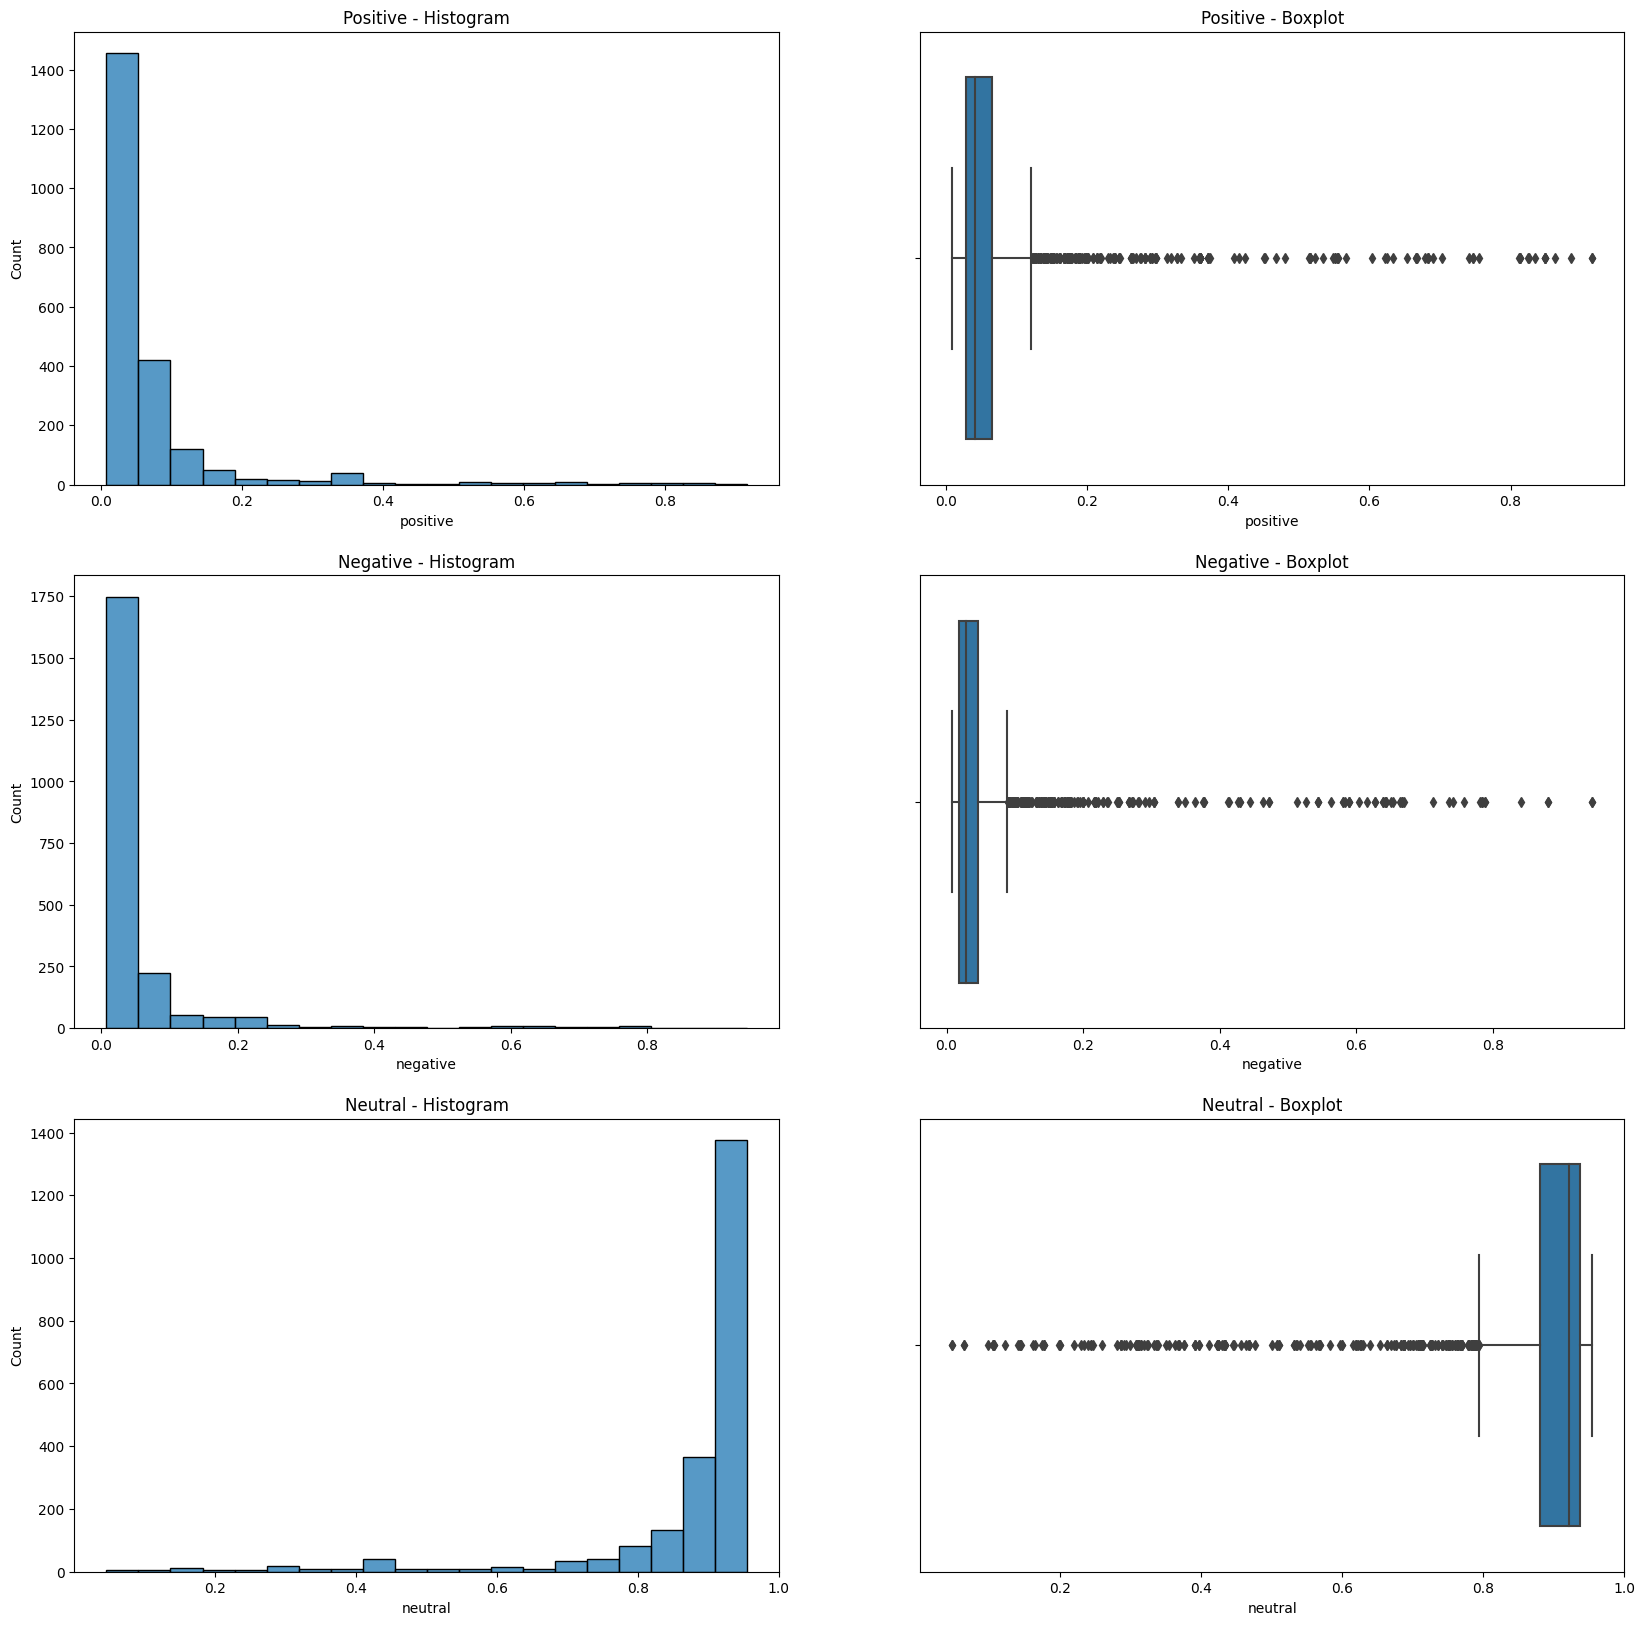

In [140]:
#Plotting Compound Data to Find Trends
fig,axs = plt.subplots(3,2,figsize=(20,20))

#positive
sns.histplot(data=df, x='positive', bins=20,ax=axs[0][0])
sns.boxplot(data=df,x ='positive',ax=axs[0][1])
axs[0][0].set_title('Positive - Histogram')
axs[0][1].set_title('Positive - Boxplot')

#negative
sns.histplot(data=df, x='negative', bins=20,ax=axs[1][0])
sns.boxplot(data=df,x ='negative',ax=axs[1][1])
axs[1][0].set_title('Negative - Histogram')
axs[1][1].set_title('Negative - Boxplot')

#neutral
sns.histplot(data=df, x='neutral', bins=20,ax=axs[2][0])
sns.boxplot(data=df,x ='neutral',ax=axs[2][1])
axs[2][0].set_title('Neutral - Histogram')
axs[2][1].set_title('Neutral - Boxplot')
plt.show()


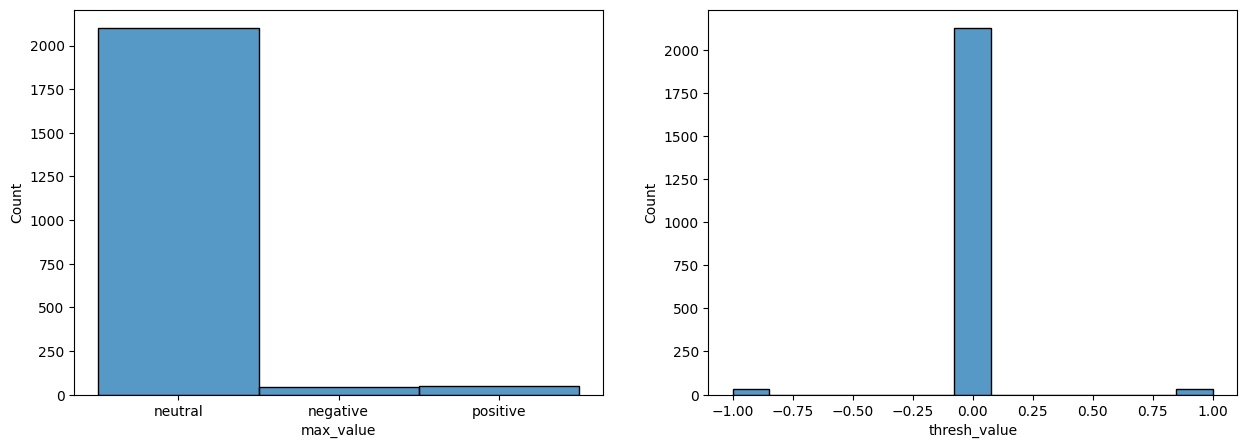

In [141]:
fig,axs = plt.subplots(1,2,figsize=(15,5))

sns.histplot(data=df, x='max_value',ax=axs[0])

sns.histplot(data=df, x='thresh_value',ax=axs[1])

plt.show()

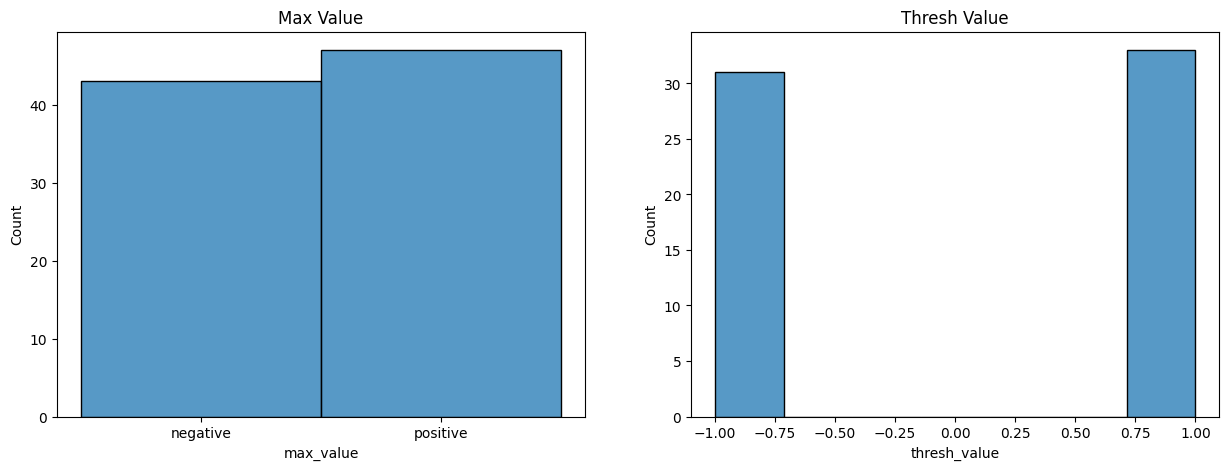

In [142]:
#Comparing thresh_value and max_value to see which is a better predictor
fig,axs = plt.subplots(1,2,figsize=(15,5))

#df with no neutral
max_value_temp = max_value[max_value['max_value']!='neutral']
thresh_value_temp = thresh_value[thresh_value['thresh_value']!=0]

#positive
sns.histplot(data=max_value_temp, x='max_value',ax=axs[0])
sns.histplot(data=thresh_value_temp,x ='thresh_value',ax=axs[1])
axs[0].set_title('Max Value')
axs[1].set_title('Thresh Value')


plt.show()



In [143]:
mismatches = df[
    ~(
        (df['thresh_value'] == 1) & (df['max_value'] == 'positive') |
        (df['thresh_value'] == -1) & (df['max_value'] == 'negative') |
        (df['thresh_value'] == 0) & (df['max_value'] == 'neutral')
     )][['positive','negative','neutral','body']]
print(len(mismatches))
mismatches

26


,positive,negative,neutral,body
199,0.548404,0.022512,0.429084,"Sally,Just wanted to say congratulations on yo..."
282,0.534246,0.018826,0.446928,"John,Regarding the employment agreement, Mike ..."
352,0.555355,0.011255,0.433390,We have secured the open marketers seat on the...
438,0.022993,0.580124,0.396883,you know i'm out and dave is out of town
443,0.019476,0.589288,0.391236,Susan discussed with you this bad $1000 propos...
601,0.522719,0.032947,0.444334,The reports below show about 2000 MW of new ge...
738,0.515274,0.017571,0.467155,$0 bid for the Redskins D
788,0.515274,0.017571,0.467155,$0 bid for the Redskins D
894,0.022855,0.513610,0.463535,Today's Enron-wide Associates PRC meeting has ...
930,0.551587,0.015343,0.433070,"Sally,I am so excited for you and your promoti..."


### Observations
+ As expected, the majority of messages have a neutral tone, which aligns with the nature of corporate communication—typically formal and objective.

+ Upon analyzing the charts, discrepancies were observed between `max_value` and `thresh_value`.
After manually reviewing some samples, it was evident that the `thresh_value` function failed to classify optimistic messages as positive.

### Conclusion:
+ The `max_value` method proved to be a more reliable predictor of sentiment, especially for capturing subtly positive messages such as congratulations, encouragement, or optimistic projections.
Therefore, `max_value will be used for the final sentiment labeling`.

In [144]:
#Extracting Different Domains to see if they sentiment trends
df['domain'] = df['from'].str.extract(r'@([\w\.]+)')


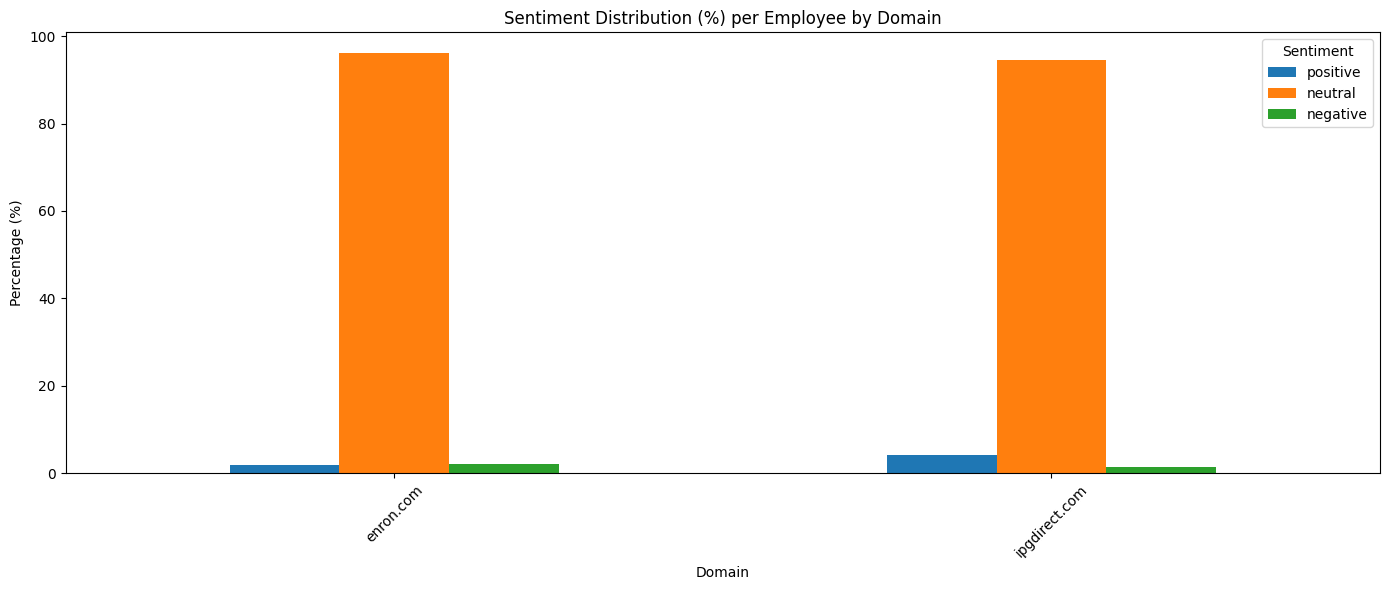

In [145]:
# Count total emails per domain
total_counts = df.groupby('domain').size()

# Count each sentiment per domain
sentiment_counts = df.groupby(['domain', 'max_value']).size().unstack(fill_value=0)

# Count employees for normalization
employee_counts = df.groupby('domain')['from'].nunique()

# Normalize sentiment count per employee
sentiment_per_employee = sentiment_counts.div(employee_counts, axis=0)

# Convert to percentages per domain
sentiment_per_employee_percent = sentiment_per_employee.div(sentiment_per_employee.sum(axis=1), axis=0) * 100

# Plot
sentiment_per_employee_percent[['positive', 'neutral', 'negative']].plot(
    kind='bar',
    figsize=(14, 6),
    title='Sentiment Distribution (%) per Employee by Domain'
)

plt.ylabel('Percentage (%)')
plt.xlabel('Domain')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


### Observation:
+ After normalizing sentiment by the number of employees per domain, we observe that ipgdirect exhibits a higher ratio of positive sentiment per employee.

In [146]:
## Extracting Year-Month Pairs
df['year_month']=df['date'].dt.to_period('M') 

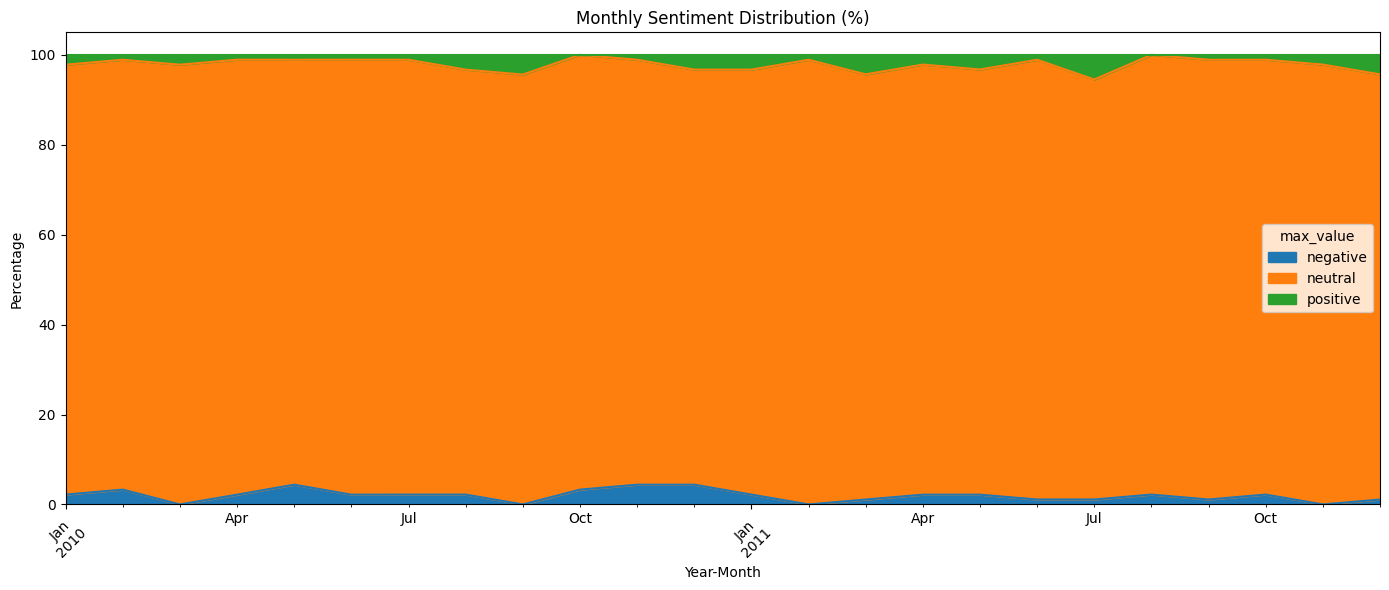

In [147]:
df_grouped = df.groupby(['year_month', 'max_value']).size().unstack(fill_value=0)
# Normalize to percentages
df_percent = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100

df_percent.plot.area(
    figsize=(14, 6),
    title='Monthly Sentiment Distribution (%)',
)
plt.ylabel('Percentage')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Observation:
+ Negative sentiment was more prevalent in early 2010, indicating possible dissatisfaction or organizational stress during that period.
+ A noticeable drop in negative sentiment occurred in 2011, suggesting a potential improvement in communication tone or workplace environment.
+ Positive sentiment increased in 2011, especially in the first half, but the trend declined toward mid-2011, possibly indicating temporary optimism or changing circumstances.



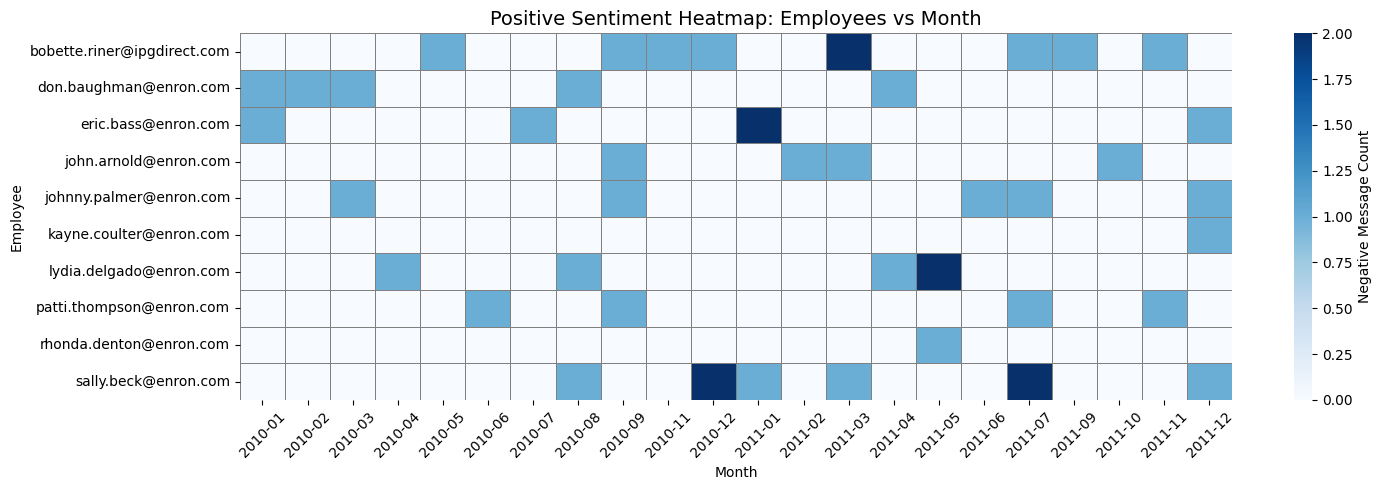

In [148]:
# Filter only negative sentiment
positive_df = df[df['max_value'] == 'positive']

# Group by year_month and employee, then count negative messages
trend_data = positive_df.groupby(['year_month', 'from']).size().unstack(fill_value=0)

# Sort months (optional, for better visual order)
trend_data = trend_data.sort_index()

# Plot heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(trend_data.T, cmap='Blues', linewidths=0.5, linecolor='gray', annot=False, cbar_kws={'label': 'Negative Message Count'})

plt.title("Positive Sentiment Heatmap: Employees vs Month", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Employee")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

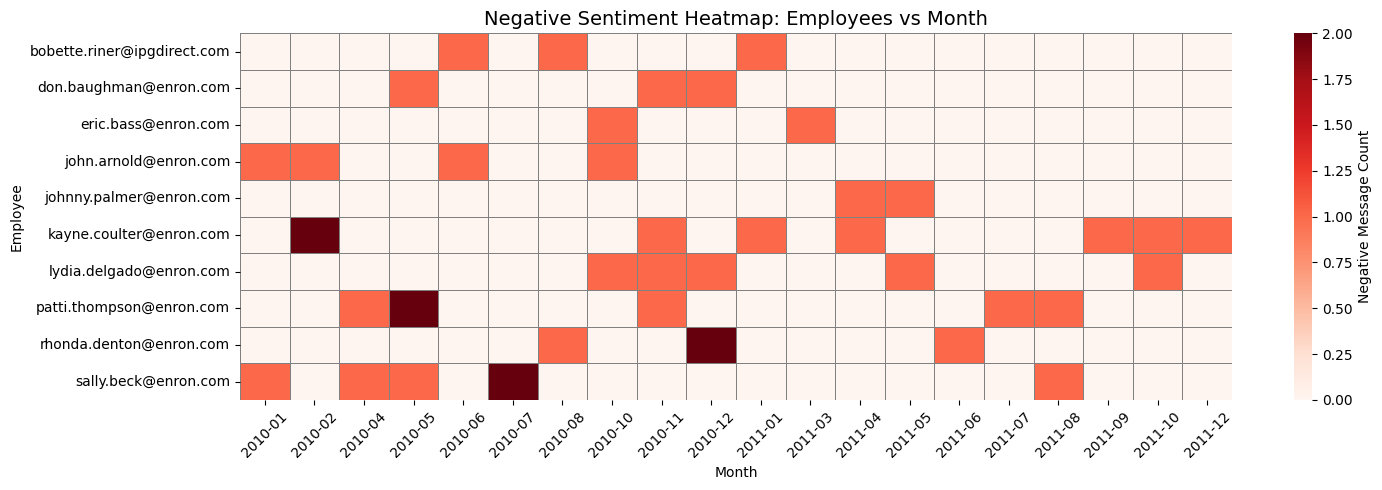

In [149]:
# Filter only negative sentiment
negative_df = df[df['max_value'] == 'negative']

# Group by year_month and employee, then count negative messages
trend_data = negative_df.groupby(['year_month', 'from']).size().unstack(fill_value=0)

# Sort months (optional, for better visual order)
trend_data = trend_data.sort_index()

# Plot heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(trend_data.T, cmap='Reds', linewidths=0.5, linecolor='gray', annot=False, cbar_kws={'label': 'Negative Message Count'})

plt.title("Negative Sentiment Heatmap: Employees vs Month", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Employee")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Observation:
+ Some employees exhibited spikes in both positive and negative sentiment during certain months, while others maintained a more consistent tone.

+ These fluctuations could indicate varying engagement or satisfaction levels, and sudden increases in negativity may signal a potential flight risk.

In [150]:
# Count body and subject words and seeing their effect on sentiments
df['body_length'] = df['body'].apply(lambda x: len(str(x).split()))
df['subject_length'] = df['Subject'].apply(lambda x: len(str(x).split()))


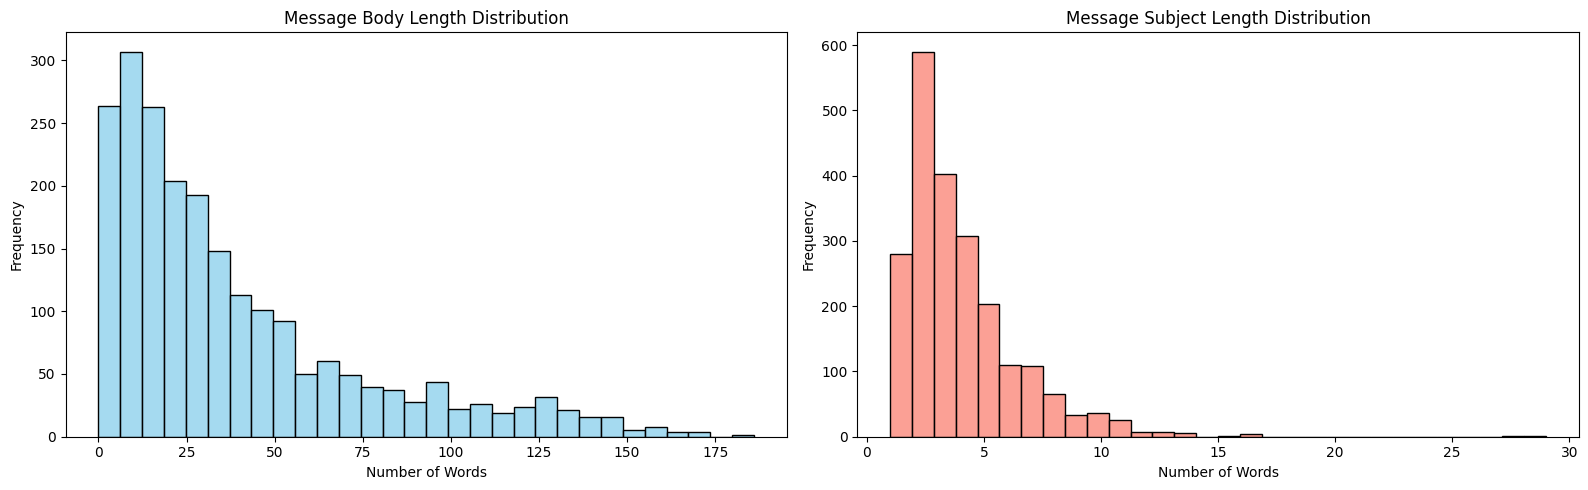

In [151]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Body Length Histogram
sns.histplot(data=df, x='body_length', bins=30, ax=axs[0], color='skyblue')
axs[0].set_title('Message Body Length Distribution')
axs[0].set_xlabel('Number of Words')
axs[0].set_ylabel('Frequency')

# Subject Length Histogram
sns.histplot(data=df, x='subject_length', bins=30, ax=axs[1], color='salmon')
axs[1].set_title('Message Subject Length Distribution')
axs[1].set_xlabel('Number of Words')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


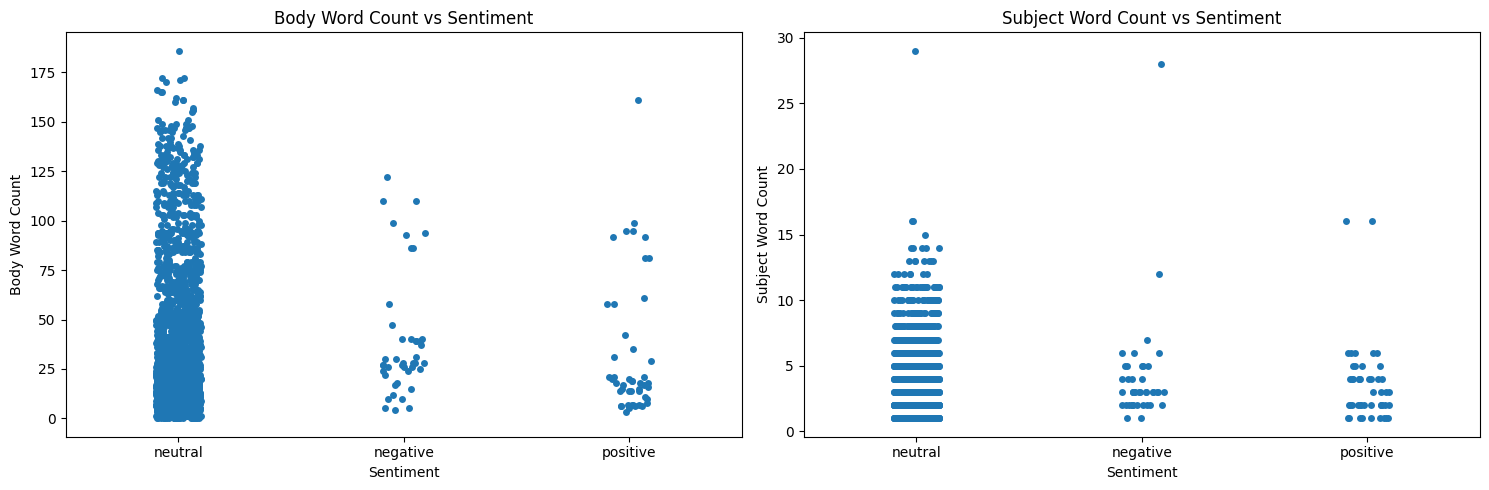

In [152]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


# Stripplot for body length
sns.stripplot(data=df, x='max_value', y='body_length', ax=axs[0])
axs[0].set_title('Body Word Count vs Sentiment')
axs[0].set_xlabel('Sentiment')
axs[0].set_ylabel('Body Word Count')

# Stripplot for subject length
sns.stripplot(data=df, x='max_value', y='subject_length', ax=axs[1])
axs[1].set_title('Subject Word Count vs Sentiment')
axs[1].set_xlabel('Sentiment')
axs[1].set_ylabel('Subject Word Count')


plt.tight_layout()
plt.show()


### Observation:
+ Most messages, regardless of sentiment, tend to have shorter subject and body word counts, indicating concise communication.
+ There is no strong correlation between sentiment and message length — both positive and negative sentiments appear across a wide range of word counts.

In [153]:
#Prepping for Correlation matrix
# Temporal features
df['day'] = df['date'].dt.day  # safer with .dt accessor
df['month'] = df['date'].dt.month  # safer with .dt accessor

#converting sentiment label into numerical data
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['message_score'] = df['max_value'].map(sentiment_map)

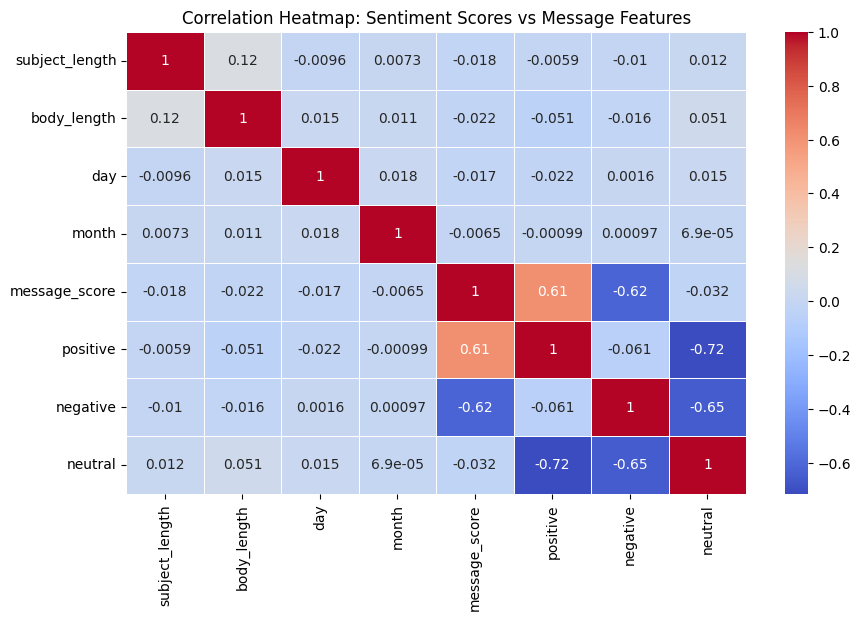

In [154]:
# Select relevant features including sentiment scores
correlation_features = df[[
    'subject_length',
    'body_length',
    'day',
    'month',
    'message_score',
    'positive',
    'negative',
    'neutral'
]]

# Compute correlation matrix
corr_matrix = correlation_features.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap: Sentiment Scores vs Message Features")
plt.show()

# EDA Observations
## Sentiment Distribution:

+ Neutral sentiment dominates the dataset, which aligns with typical corporate communication.
+ Positive and negative sentiments occur less frequently, with some spikes for certain employees and time periods.

## Time-based Trends:
+ Negative sentiment was more prevalent in early 2010, dropping in 2011.
+ Positive sentiment peaked in early 2011 but declined mid-year, possibly due to changing organizational dynamics.

## Employee Sentiment Patterns:

+ Some employees showed spikes in both positive and negative sentiment over time.
+ These irregularities may hint at job dissatisfaction or sudden changes in behavior — potential flight risk indicators.

## Domain-wise Sentiment:

+ When normalized by employee count, some domains like ipgdirect show a higher proportion of positive sentiment per person.
+ Message and Subject Lengths:
+ Most messages (subject and body) are short.
+ There’s no strong correlation between sentiment and message length.

## Correlation Insights:
+ Message length and temporal features (day, month) show very weak correlations with sentiment.

# Conclusion
+ The max_value method provides more reliable sentiment labeling than thresholds, especially for capturing subtly positive messages.
+ Employee-wise sentiment trend visualizations can offer early indicators of employee disengagement or workplace stress.
+ Domain-wise normalization reveals which organizational units may have higher or lower morale, enabling targeted interventions.
+ While message and subject length are not highly predictive of sentiment, they confirm that short and concise communication is standard.

+ The correlation matrix validates that sentiment scores behave as expected (e.g., high positive = low negative), and that message structure (length, date) has minimal influence.



# 3. Employee Monthly Scores

In [155]:
#grouping by from and year_month creates a group for every employee with subgroups for all months
# the final sum provides the monthly score
monthly_score = df.groupby(['from', 'year_month'])['message_score'].sum().reset_index().rename(columns={'message_score':'monthly_score'})

In [156]:
# Merge monthly_score back into the original DataFrame
df = df.merge(monthly_score, on=['from', 'year_month'], how='left').fillna(0)

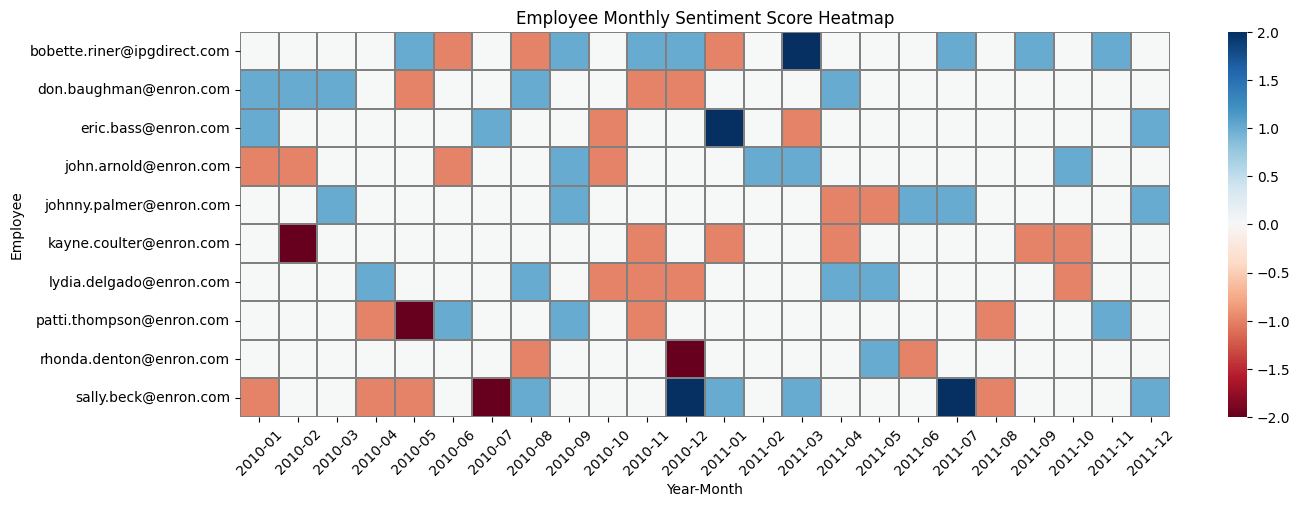

In [157]:
# Pivot for heatmap
heatmap_df = monthly_score.pivot(index='from', columns='year_month', values='monthly_score').fillna(0)

plt.figure(figsize=(15, 5))
sns.heatmap(heatmap_df, cmap='RdBu', linewidths=0.3, linecolor='grey')

plt.title('Employee Monthly Sentiment Score Heatmap')
plt.xlabel('Year-Month')
plt.ylabel('Employee')
plt.xticks(rotation=45)
plt.show()


## Observations:
+ Most employees maintained a neutral sentiment trend over time, which aligns with the formal tone of corporate communication - this further confirms the results of the EDA.
+ However, some employees showed noticeable spikes in their monthly message scores—both positive and negative—during certain periods.

# 4. Employee Ranking

In [158]:
# Remove all rows with zeros and -ves for better results
monthly_score_pos = monthly_score[monthly_score['monthly_score']>0]

## First group by year_month to get employees for every month
## apply nlargest and nsmallest on every group
pos_top3 = monthly_score_pos.groupby('year_month').apply(lambda x:x.nlargest(3,'monthly_score'),include_groups=False).reset_index(level=1,drop=True)
pos_top3.sort_values(by=['year_month','monthly_score','from'],ascending=[True,False,True])

,from,monthly_score
year_month,,
2010-01,don.baughman@enron.com,1
2010-01,eric.bass@enron.com,1
2010-02,don.baughman@enron.com,1
2010-03,don.baughman@enron.com,1
2010-03,johnny.palmer@enron.com,1
2010-04,lydia.delgado@enron.com,1
2010-05,bobette.riner@ipgdirect.com,1
2010-06,patti.thompson@enron.com,1
2010-07,eric.bass@enron.com,1


In [159]:
# Remove all rows with zeros and +ves  for better results
monthly_score_neg = monthly_score[monthly_score['monthly_score']< 0]

neg_top3 = monthly_score_neg.groupby('year_month').apply(lambda x:x.nsmallest(3,'monthly_score'),include_groups=False).reset_index(level=1,drop=True)
neg_top3.sort_values(by=['year_month','monthly_score','from'],ascending=[True,False,True])

,from,monthly_score
year_month,,
2010-01,john.arnold@enron.com,-1
2010-01,sally.beck@enron.com,-1
2010-02,john.arnold@enron.com,-1
2010-02,kayne.coulter@enron.com,-2
2010-04,patti.thompson@enron.com,-1
2010-04,sally.beck@enron.com,-1
2010-05,don.baughman@enron.com,-1
2010-05,sally.beck@enron.com,-1
2010-05,patti.thompson@enron.com,-2


## Identifying Top Positive and Negative Contributors (Monthly)
### Steps: 
1. **Filter Out Neutral Entries**:  
   - For positives: Keep only rows where `monthly_score > 0`.  
   - For negatives: Keep only rows where `monthly_score < 0`.

2. **Group by Month**:  
   Group the filtered data by `year_month` to isolate sentiment per month.

3. **Select Top/Bottom Performers**:  
   - Use `nlargest(3)` to get the top 3 positive contributors per month.  
   - Use `nsmallest(3)` to get the bottom 3 (most negative) contributors per month.

4. **Sort for Clarity**:  
   Sorted the results by `year_month`, `monthly_score`, and employee name (`from`)


In [180]:
neg_top3.to_csv('Negative.csv', index=False)
pos_top3.to_csv('Positive.csv', index=False)

# 5. Flight Risks

In [160]:
def flight_risks(df,threshold,window='30D'):
    #Filtering Message with negative sentiment
    df_neg=df[df['message_score']==-1]
    flight_risks=set()
    
    #sorting and indexing required for rolling window
    df_neg_sorted = df_neg.sort_values('date') 
    df_neg_sorted_indexed = df_neg_sorted.set_index('date')
    
    for employee,row in df_neg_sorted_indexed.groupby('from'):
        rolling_count = row['message_score'].rolling(window).sum()
        if(rolling_count<=-threshold).any():
            flight_risks.add(employee)
            
    return flight_risks
    

In [161]:
print (f'Threshold : 4 {flight_risks(df,4)}')

Threshold : 4 set()


### Observation: 
 + When using a threshold of 4 or more negative emails per month, no employees qualify as flight risks.

In [162]:
for i in range(2,4):
    print (f'Threshold : {i} {flight_risks(df,i)}')

Threshold : 2 {'lydia.delgado@enron.com', 'john.arnold@enron.com', 'sally.beck@enron.com', 'patti.thompson@enron.com', 'kayne.coulter@enron.com', 'rhonda.denton@enron.com'}
Threshold : 3 {'patti.thompson@enron.com'}


# 6. Regression Model

In [163]:
#looking at the columns before feature engineering
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Subject         2191 non-null   object        
 1   body            2191 non-null   object        
 2   date            2191 non-null   datetime64[ns]
 3   from            2191 non-null   object        
 4   positive        2191 non-null   float64       
 5   negative        2191 non-null   float64       
 6   neutral         2191 non-null   float64       
 7   max_value       2191 non-null   object        
 8   thresh_value    2191 non-null   int64         
 9   domain          2191 non-null   object        
 10  year_month      2191 non-null   period[M]     
 11  body_length     2191 non-null   int64         
 12  subject_length  2191 non-null   int64         
 13  day             2191 non-null   int32         
 14  month           2191 non-null   int32         
 15  mess

In [164]:
#total number of exclamation marks
df['total_excl'] = df['body'].str.count('!') + df['Subject'].str.count('!')
df['total_punc'] = df['body'].str.count(r'[\;\,\.\?]+')
# day and month columns
df['total_excl'].fillna(0,inplace=True)
df['total_punc'].fillna(0,inplace=True)

In [165]:
#extracting average number of messages each month for each employee
temp=df.groupby(['year_month', 'from']).size().reset_index(name='avg_monthly_message')
temp.drop('year_month',axis=1,inplace=True)
temp=temp.groupby('from').mean()

df = df.merge(temp, on='from', how='left')

In [166]:
#extracting message count w.r.t each month for each employee
df['message_number']=df.groupby(['from','year_month']).cumcount()+1

In [167]:
# Loughran and McDonald Sentiment Word Lists
word_list = {'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated',
                       'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational',
                       'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish',
                       'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating',
                       'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences',
                       'absenteeism', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abusively', 'abusiveness',
                       'accident', 'accidental', 'accidentally', 'accidents', 'accusation', 'accusations', 'accuse',
                       'accused', 'accuses', 'accusing', 'acquiesce', 'acquiesced', 'acquiesces', 'acquiescing',
                       'acquit', 'acquits', 'acquittal', 'acquittals', 'acquitted', 'acquitting', 'adulterate',
                       'adulterated', 'adulterating', 'adulteration', 'adulterations', 'adversarial', 'adversaries',
                       'adversary', 'adverse', 'adversely', 'adversities', 'adversity', 'aftermath', 'aftermaths',
                       'against', 'aggravate', 'aggravated', 'aggravates', 'aggravating', 'aggravation', 'aggravations',
                       'alerted', 'alerting', 'alienate', 'alienated', 'alienates', 'alienating', 'alienation',
                       'alienations', 'allegation', 'allegations', 'allege', 'alleged', 'allegedly', 'alleges',
                       'alleging', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoys', 'annul',
                       'annulled', 'annulling', 'annulment', 'annulments', 'annuls', 'anomalies', 'anomalous',
                       'anomalously', 'anomaly', 'anticompetitive', 'antitrust', 'argue', 'argued', 'arguing',
                       'argument', 'argumentative', 'arguments', 'arrearage', 'arrearages', 'arrears', 'arrest',
                       'arrested', 'arrests', 'artificially', 'assault', 'assaulted', 'assaulting', 'assaults',
                       'assertions', 'attrition', 'aversely', 'backdating', 'bad', 'bail', 'bailout', 'balk', 'balked',
                       'bankrupt', 'bankruptcies', 'bankruptcy', 'bankrupted', 'bankrupting', 'bankrupts', 'bans',
                       'barred', 'barrier', 'barriers', 'bottleneck', 'bottlenecks', 'boycott', 'boycotted',
                       'boycotting', 'boycotts', 'breach', 'breached', 'breaches', 'breaching', 'break', 'breakage',
                       'breakages', 'breakdown', 'breakdowns', 'breaking', 'breaks', 'bribe', 'bribed', 'briberies',
                       'bribery', 'bribes', 'bribing', 'bridge', 'broken', 'burden', 'burdened', 'burdening', 'burdens',
                       'burdensome', 'burned', 'calamities', 'calamitous', 'calamity', 'cancel', 'canceled',
                       'canceling', 'cancellation', 'cancellations', 'cancelled', 'cancelling', 'cancels', 'careless',
                       'carelessly', 'carelessness', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically',
                       'caution', 'cautionary', 'cautioned', 'cautioning', 'cautions', 'cease', 'ceased', 'ceases',
                       'ceasing', 'censure', 'censured', 'censures', 'censuring', 'challenge', 'challenged',
                       'challenges', 'challenging', 'chargeoffs', 'circumvent', 'circumvented', 'circumventing',
                       'circumvention', 'circumventions', 'circumvents', 'claiming', 'claims', 'clawback', 'closed',
                       'closeout', 'closeouts', 'closing', 'closings', 'closure', 'closures', 'coerce', 'coerced',
                       'coerces', 'coercing', 'coercion', 'coercive', 'collapse', 'collapsed', 'collapses',
                       'collapsing', 'collision', 'collisions', 'collude', 'colluded', 'colludes', 'colluding',
                       'collusion', 'collusions', 'collusive', 'complain', 'complained', 'complaining', 'complains',
                       'complaint', 'complaints', 'complicate', 'complicated', 'complicates', 'complicating',
                       'complication', 'complications', 'compulsion', 'concealed', 'concealing', 'concede', 'conceded',
                       'concedes', 'conceding', 'concern', 'concerned', 'concerns', 'conciliating', 'conciliation',
                       'conciliations', 'condemn', 'condemnation', 'condemnations', 'condemned', 'condemning',
                       'condemns', 'condone', 'condoned', 'confess', 'confessed', 'confesses', 'confessing',
                       'confession', 'confine', 'confined', 'confinement', 'confinements', 'confines', 'confining',
                       'confiscate', 'confiscated', 'confiscates', 'confiscating', 'confiscation', 'confiscations',
                       'conflict', 'conflicted', 'conflicting', 'conflicts', 'confront', 'confrontation',
                       'confrontational', 'confrontations', 'confronted', 'confronting', 'confronts', 'confuse',
                       'confused', 'confuses', 'confusing', 'confusingly', 'confusion', 'conspiracies', 'conspiracy',
                       'conspirator', 'conspiratorial', 'conspirators', 'conspire', 'conspired', 'conspires',
                       'conspiring', 'contempt', 'contend', 'contended', 'contending', 'contends', 'contention',
                       'contentions', 'contentious', 'contentiously', 'contested', 'contesting', 'contraction',
                       'contractions', 'contradict', 'contradicted', 'contradicting', 'contradiction', 'contradictions',
                       'contradictory', 'contradicts', 'contrary', 'controversial', 'controversies', 'controversy',
                       'convict', 'convicted', 'convicting', 'conviction', 'convictions', 'corrected', 'correcting',
                       'correction', 'corrections', 'corrects', 'corrupt', 'corrupted', 'corrupting', 'corruption',
                       'corruptions', 'corruptly', 'corruptness', 'costly', 'counterclaim', 'counterclaimed',
                       'counterclaiming', 'counterclaims', 'counterfeit', 'counterfeited', 'counterfeiter',
                       'counterfeiters', 'counterfeiting', 'counterfeits', 'countermeasure', 'countermeasures', 'crime',
                       'crimes', 'criminal', 'criminally', 'criminals', 'crises', 'crisis', 'critical', 'critically',
                       'criticism', 'criticisms', 'criticize', 'criticized', 'criticizes', 'criticizing', 'crucial',
                       'crucially', 'culpability', 'culpable', 'culpably', 'cumbersome', 'curtail', 'curtailed',
                       'curtailing', 'curtailment', 'curtailments', 'curtails', 'cut', 'cutback', 'cutbacks',
                       'cyberattack', 'cyberattacks', 'cyberbullying', 'cybercrime', 'cybercrimes', 'cybercriminal',
                       'cybercriminals', 'damage', 'damaged', 'damages', 'damaging', 'dampen', 'dampened', 'danger',
                       'dangerous', 'dangerously', 'dangers', 'deadlock', 'deadlocked', 'deadlocking', 'deadlocks',
                       'deadweight', 'deadweights', 'debarment', 'debarments', 'debarred', 'deceased', 'deceit',
                       'deceitful', 'deceitfulness', 'deceive', 'deceived', 'deceives', 'deceiving', 'deception',
                       'deceptions', 'deceptive', 'deceptively', 'decline', 'declined', 'declines', 'declining',
                       'deface', 'defaced', 'defacement', 'defamation', 'defamations', 'defamatory', 'defame',
                       'defamed', 'defames', 'defaming', 'default', 'defaulted', 'defaulting', 'defaults', 'defeat',
                       'defeated', 'defeating', 'defeats', 'defect', 'defective', 'defects', 'defend', 'defendant',
                       'defendants', 'defended', 'defending', 'defends', 'defensive', 'defer', 'deficiencies',
                       'deficiency', 'deficient', 'deficit', 'deficits', 'defraud', 'defrauded', 'defrauding',
                       'defrauds', 'defunct', 'degradation', 'degradations', 'degrade', 'degraded', 'degrades',
                       'degrading', 'delay', 'delayed', 'delaying', 'delays', 'deleterious', 'deliberate',
                       'deliberated', 'deliberately', 'delinquencies', 'delinquency', 'delinquent', 'delinquently',
                       'delinquents', 'delist', 'delisted', 'delisting', 'delists', 'demise', 'demised', 'demises',
                       'demising', 'demolish', 'demolished', 'demolishes', 'demolishing', 'demolition', 'demolitions',
                       'demote', 'demoted', 'demotes', 'demoting', 'demotion', 'demotions', 'denial', 'denials',
                       'denied', 'denies', 'denigrate', 'denigrated', 'denigrates', 'denigrating', 'denigration',
                       'deny', 'denying', 'deplete', 'depleted', 'depletes', 'depleting', 'depletion', 'depletions',
                       'deprecation', 'depress', 'depressed', 'depresses', 'depressing', 'deprivation', 'deprive',
                       'deprived', 'deprives', 'depriving', 'derelict', 'dereliction', 'derogatory', 'destabilization',
                       'destabilize', 'destabilized', 'destabilizing', 'destroy', 'destroyed', 'destroying', 'destroys',
                       'destruction', 'destructive', 'detain', 'detained', 'detention', 'detentions', 'deter',
                       'deteriorate', 'deteriorated', 'deteriorates', 'deteriorating', 'deterioration',
                       'deteriorations', 'deterred', 'deterrence', 'deterrences', 'deterrent', 'deterrents',
                       'deterring', 'deters', 'detract', 'detracted', 'detracting', 'detriment', 'detrimental',
                       'detrimentally', 'detriments', 'devalue', 'devalued', 'devalues', 'devaluing', 'devastate',
                       'devastated', 'devastating', 'devastation', 'deviate', 'deviated', 'deviates', 'deviating',
                       'deviation', 'deviations', 'devolve', 'devolved', 'devolves', 'devolving', 'difficult',
                       'difficulties', 'difficultly', 'difficulty', 'diminish', 'diminished', 'diminishes',
                       'diminishing', 'diminution', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages',
                       'disaffiliation', 'disagree', 'disagreeable', 'disagreed', 'disagreeing', 'disagreement',
                       'disagreements', 'disagrees', 'disallow', 'disallowance', 'disallowances', 'disallowed',
                       'disallowing', 'disallows', 'disappear', 'disappearance', 'disappearances', 'disappeared',
                       'disappearing', 'disappears', 'disappoint', 'disappointed', 'disappointing', 'disappointingly',
                       'disappointment', 'disappointments', 'disappoints', 'disapproval', 'disapprovals', 'disapprove',
                       'disapproved', 'disapproves', 'disapproving', 'disassociates', 'disassociating',
                       'disassociation', 'disassociations', 'disaster', 'disasters', 'disastrous', 'disastrously',
                       'disavow', 'disavowal', 'disavowed', 'disavowing', 'disavows', 'disciplinary', 'disclaim',
                       'disclaimed', 'disclaimer', 'disclaimers', 'disclaiming', 'disclaims', 'disclose', 'disclosed',
                       'discloses', 'disclosing', 'discontinuance', 'discontinuances', 'discontinuation',
                       'discontinuations', 'discontinue', 'discontinued', 'discontinues', 'discontinuing', 'discourage',
                       'discouraged', 'discourages', 'discouraging', 'discredit', 'discredited', 'discrediting',
                       'discredits', 'discrepancies', 'discrepancy', 'disfavor', 'disfavored', 'disfavoring',
                       'disfavors', 'disgorge', 'disgorged', 'disgorgement', 'disgorgements', 'disgorges', 'disgorging',
                       'disgrace', 'disgraceful', 'disgracefully', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor',
                       'dishonorable', 'dishonorably', 'dishonored', 'dishonoring', 'dishonors', 'disincentives',
                       'disinterested', 'disinterestedly', 'disinterestedness', 'disloyal', 'disloyally', 'disloyalty',
                       'dismal', 'dismally', 'dismiss', 'dismissal', 'dismissals', 'dismissed', 'dismisses',
                       'dismissing', 'disorderly', 'disparage', 'disparaged', 'disparagement', 'disparagements',
                       'disparages', 'disparaging', 'disparagingly', 'disparities', 'disparity', 'displace',
                       'displaced', 'displacement', 'displacements', 'displaces', 'displacing', 'dispose', 'dispossess',
                       'dispossessed', 'dispossesses', 'dispossessing', 'disproportion', 'disproportional',
                       'disproportionate', 'disproportionately', 'dispute', 'disputed', 'disputes', 'disputing',
                       'disqualification', 'disqualifications', 'disqualified', 'disqualifies', 'disqualify',
                       'disqualifying', 'disregard', 'disregarded', 'disregarding', 'disregards', 'disreputable',
                       'disrepute', 'disrupt', 'disrupted', 'disrupting', 'disruption', 'disruptions', 'disruptive',
                       'disrupts', 'dissatisfaction', 'dissatisfied', 'dissent', 'dissented', 'dissenter', 'dissenters',
                       'dissenting', 'dissents', 'dissident', 'dissidents', 'dissolution', 'dissolutions', 'distort',
                       'distorted', 'distorting', 'distortion', 'distortions', 'distorts', 'distract', 'distracted',
                       'distracting', 'distraction', 'distractions', 'distracts', 'distress', 'distressed', 'disturb',
                       'disturbance', 'disturbances', 'disturbed', 'disturbing', 'disturbs', 'diversion', 'divert',
                       'diverted', 'diverting', 'diverts', 'divest', 'divested', 'divesting', 'divestiture',
                       'divestitures', 'divestment', 'divestments', 'divests', 'divorce', 'divorced', 'divulge',
                       'divulged', 'divulges', 'divulging', 'doubt', 'doubted', 'doubtful', 'doubts', 'downgrade',
                       'downgraded', 'downgrades', 'downgrading', 'downsize', 'downsized', 'downsizes', 'downsizing',
                       'downsizings', 'downtime', 'downtimes', 'downturn', 'downturns', 'downward', 'downwards', 'drag',
                       'drastic', 'drastically', 'drawback', 'drawbacks', 'drop', 'dropped', 'drought', 'droughts', 'duress',
                       'dysfunction', 'dysfunctional', 'dysfunctions', 'easing', 'egregious', 'egregiously', 'embargo',
                       'embargoed', 'embargoes', 'embargoing', 'embarrass', 'embarrassed', 'embarrasses',
                       'embarrassing', 'embarrassment', 'embarrassments', 'embezzle', 'embezzled', 'embezzlement',
                       'embezzlements', 'embezzler', 'embezzles', 'embezzling', 'encroach', 'encroached', 'encroaches',
                       'encroaching', 'encroachment', 'encroachments', 'encumber', 'encumbered', 'encumbering',
                       'encumbers', 'encumbrance', 'encumbrances', 'endanger', 'endangered', 'endangering',
                       'endangerment', 'endangers', 'enjoin', 'enjoined', 'enjoining', 'enjoins', 'erode', 'eroded',
                       'erodes', 'eroding', 'erosion', 'erratic', 'erratically', 'erred', 'erring', 'erroneous',
                       'erroneously', 'error', 'errors', 'errs', 'escalate', 'escalated', 'escalates', 'escalating',
                       'evade', 'evaded', 'evades', 'evading', 'evasion', 'evasions', 'evasive', 'evict', 'evicted',
                       'evicting', 'eviction', 'evictions', 'evicts', 'exacerbate', 'exacerbated', 'exacerbates',
                       'exacerbating', 'exacerbation', 'exacerbations', 'exaggerate', 'exaggerated', 'exaggerates',
                       'exaggerating', 'exaggeration', 'excessive', 'excessively', 'exculpate', 'exculpated',
                       'exculpates', 'exculpating', 'exculpation', 'exculpations', 'exculpatory', 'exonerate',
                       'exonerated', 'exonerates', 'exonerating', 'exoneration', 'exonerations', 'exploit',
                       'exploitation', 'exploitations', 'exploitative', 'exploited', 'exploiting', 'exploits', 'expose',
                       'exposed', 'exposes', 'exposing', 'expropriate', 'expropriated', 'expropriates', 'expropriating',
                       'expropriation', 'expropriations', 'expulsion', 'expulsions', 'extenuating', 'fail', 'failed',
                       'failing', 'failings', 'fails', 'failure', 'failures', 'fallout', 'false', 'falsely',
                       'falsification', 'falsifications', 'falsified', 'falsifies', 'falsify', 'falsifying', 'falsity',
                       'fatalities', 'fatality', 'fatally', 'fault', 'faulted', 'faults', 'faulty', 'fear', 'fears',
                       'felonies', 'felonious', 'felony', 'fictitious', 'fined', 'fines', 'fired', 'firing', 'flaw',
                       'flawed', 'flaws', 'forbid', 'forbidden', 'forbidding', 'forbids', 'force', 'forced', 'forcing',
                       'foreclose', 'foreclosed', 'forecloses', 'foreclosing', 'foreclosure', 'foreclosures', 'forego',
                       'foregoes', 'foregone', 'forestall', 'forestalled', 'forestalling', 'forestalls', 'forfeit',
                       'forfeited', 'forfeiting', 'forfeits', 'forfeiture', 'forfeitures', 'forgers', 'forgery',
                       'fraud', 'frauds', 'fraudulence', 'fraudulent', 'fraudulently', 'frivolous', 'frivolously',
                       'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration',
                       'frustrations', 'fugitive', 'fugitives', 'gratuitous', 'gratuitously', 'grievance', 'grievances',
                       'grossly', 'groundless', 'guilty', 'halt', 'halted', 'hamper', 'hampered', 'hampering',
                       'hampers', 'harass', 'harassed', 'harassing', 'harassment', 'hardship', 'hardships', 'harm',
                       'harmed', 'harmful', 'harmfully', 'harming', 'harms', 'harsh', 'harsher', 'harshest', 'harshly',
                       'harshness', 'hazard', 'hazardous', 'hazards', 'hinder', 'hindered', 'hindering', 'hinders',
                       'hindrance', 'hindrances', 'hostile', 'hostility', 'hurt', 'hurting', 'idle', 'idled', 'idling',
                       'ignore', 'ignored', 'ignores', 'ignoring', 'ill', 'illegal', 'illegalities', 'illegality',
                       'illegally', 'illegible', 'illicit', 'illicitly', 'illiquid', 'illiquidity', 'imbalance',
                       'imbalances', 'immature', 'immoral', 'impair', 'impaired', 'impairing', 'impairment',
                       'impairments', 'impairs', 'impasse', 'impasses', 'impede', 'impeded', 'impedes', 'impediment',
                       'impediments', 'impeding', 'impending', 'imperative', 'imperfection', 'imperfections', 'imperil',
                       'impermissible', 'implicate', 'implicated', 'implicates', 'implicating', 'impossibility',
                       'impossible', 'impound', 'impounded', 'impounding', 'impounds', 'impracticable', 'impractical',
                       'impracticalities', 'impracticality', 'imprisonment', 'improper', 'improperly', 'improprieties',
                       'impropriety', 'imprudent', 'imprudently', 'inability', 'inaccessible', 'inaccuracies',
                       'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactions', 'inactivate', 'inactivated',
                       'inactivates', 'inactivating', 'inactivation', 'inactivations', 'inactivity', 'inadequacies',
                       'inadequacy', 'inadequate', 'inadequately', 'inadvertent', 'inadvertently', 'inadvisability',
                       'inadvisable', 'inappropriate', 'inappropriately', 'inattention', 'incapable', 'incapacitated',
                       'incapacity', 'incarcerate', 'incarcerated', 'incarcerates', 'incarcerating', 'incarceration',
                       'incarcerations', 'incidence', 'incidences', 'incident', 'incidents', 'incompatibilities',
                       'incompatibility', 'incompatible', 'incompetence', 'incompetency', 'incompetent',
                       'incompetently', 'incompetents', 'incomplete', 'incompletely', 'incompleteness', 'inconclusive',
                       'inconsistencies', 'inconsistency', 'inconsistent', 'inconsistently', 'inconvenience',
                       'inconveniences', 'inconvenient', 'incorrect', 'incorrectly', 'incorrectness', 'indecency',
                       'indecent', 'indefeasible', 'indefeasibly', 'indict', 'indictable', 'indicted', 'indicting',
                       'indictment', 'indictments', 'ineffective', 'ineffectively', 'ineffectiveness', 'inefficiencies',
                       'inefficiency', 'inefficient', 'inefficiently', 'ineligibility', 'ineligible', 'inequitable',
                       'inequitably', 'inequities', 'inequity', 'inevitable', 'inexperience', 'inexperienced',
                       'inferior', 'inflicted', 'infraction', 'infractions', 'infringe', 'infringed', 'infringement',
                       'infringements', 'infringes', 'infringing', 'inhibited', 'inimical', 'injunction', 'injunctions',
                       'injure', 'injured', 'injures', 'injuries', 'injuring', 'injurious', 'injury', 'inordinate',
                       'inordinately', 'inquiry', 'insecure', 'insensitive', 'insolvencies', 'insolvency', 'insolvent',
                       'instability', 'insubordination', 'insufficiency', 'insufficient', 'insufficiently',
                       'insurrection', 'insurrections', 'intentional', 'interfere', 'interfered', 'interference',
                       'interferences', 'interferes', 'interfering', 'intermittent', 'intermittently', 'interrupt',
                       'interrupted', 'interrupting', 'interruption', 'interruptions', 'interrupts', 'intimidation',
                       'intrusion', 'invalid', 'invalidate', 'invalidated', 'invalidates', 'invalidating',
                       'invalidation', 'invalidity', 'investigate', 'investigated', 'investigates', 'investigating',
                       'investigation', 'investigations', 'involuntarily', 'involuntary', 'irreconcilable',
                       'irreconcilably', 'irrecoverable', 'irrecoverably', 'irregular', 'irregularities',
                       'irregularity', 'irregularly', 'irreparable', 'irreparably', 'irreversible', 'jeopardize',
                       'jeopardized', 'justifiable', 'kickback', 'kickbacks', 'knowingly', 'lack', 'lacked', 'lacking',
                       'lackluster', 'lacks', 'lag', 'lagged', 'lagging', 'lags', 'lapse', 'lapsed', 'lapses',
                       'lapsing', 'late', 'laundering', 'layoff', 'layoffs', 'lie', 'limitation', 'limitations',
                       'lingering', 'liquidate', 'liquidated', 'liquidates', 'liquidating', 'liquidation',
                       'liquidations', 'liquidator', 'liquidators', 'litigant', 'litigants', 'litigate', 'litigated',
                       'litigates', 'litigating', 'litigation', 'litigations', 'lockout', 'lockouts', 'lose', 'loses',
                       'losing', 'loss', 'losses', 'lost', 'lying', 'malfeasance', 'malfunction', 'malfunctioned',
                       'malfunctioning', 'malfunctions', 'malice', 'malicious', 'maliciously', 'malpractice',
                       'manipulate', 'manipulated', 'manipulates', 'manipulating', 'manipulation', 'manipulations',
                       'manipulative', 'markdown', 'markdowns', 'misapplication', 'misapplications', 'misapplied',
                       'misapplies', 'misapply', 'misapplying', 'misappropriate', 'misappropriated', 'misappropriates',
                       'misappropriating', 'misappropriation', 'misappropriations', 'misbranded', 'miscalculate',
                       'miscalculated', 'miscalculates', 'miscalculating', 'miscalculation', 'miscalculations',
                       'mischaracterization', 'mischief', 'misclassification', 'misclassifications', 'misclassified',
                       'misclassify', 'miscommunication', 'misconduct', 'misdated', 'misdemeanor', 'misdemeanors',
                       'misdirected', 'mishandle', 'mishandled', 'mishandles', 'mishandling', 'misinform',
                       'misinformation', 'misinformed', 'misinforming', 'misinforms', 'misinterpret',
                       'misinterpretation', 'misinterpretations', 'misinterpreted', 'misinterpreting', 'misinterprets',
                       'misjudge', 'misjudged', 'misjudges', 'misjudging', 'misjudgment', 'misjudgments', 'mislabel',
                       'mislabeled', 'mislabeling', 'mislabelled', 'mislabels', 'mislead', 'misleading', 'misleadingly',
                       'misleads', 'misled', 'mismanage', 'mismanaged', 'mismanagement', 'mismanages', 'mismanaging',
                       'mismatch', 'mismatched', 'mismatches', 'mismatching', 'misplaced', 'misprice', 'mispricing',
                       'mispricings', 'misrepresent', 'misrepresentation', 'misrepresentations', 'misrepresented',
                       'misrepresenting', 'misrepresents', 'miss', 'missed', 'misses', 'misstate', 'misstated',
                       'misstatement', 'misstatements', 'misstates', 'misstating', 'misstep', 'missteps', 'mistake',
                       'mistaken', 'mistakenly', 'mistakes', 'mistaking', 'mistrial', 'mistrials', 'misunderstand',
                       'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'misused', 'misuses',
                       'misusing', 'monopolistic', 'monopolists', 'monopolization', 'monopolize', 'monopolized',
                       'monopolizes', 'monopolizing', 'monopoly', 'moratoria', 'moratorium', 'moratoriums',
                       'mothballed', 'mothballing', 'negative', 'negatively', 'negatives', 'neglect', 'neglected',
                       'neglectful', 'neglecting', 'neglects', 'negligence', 'negligences', 'negligent', 'negligently',
                       'nonattainment', 'noncompetitive', 'noncompliance', 'noncompliances', 'noncompliant',
                       'noncomplying', 'nonconforming', 'nonconformities', 'nonconformity', 'nondisclosure',
                       'nonfunctional', 'nonpayment', 'nonpayments', 'nonperformance', 'nonperformances',
                       'nonperforming', 'nonproducing', 'nonproductive', 'nonrecoverable', 'nonrenewal', 'nuisance',
                       'nuisances', 'nullification', 'nullifications', 'nullified', 'nullifies', 'nullify',
                       'nullifying', 'objected', 'objecting', 'objection', 'objectionable', 'objectionably',
                       'objections', 'obscene', 'obscenity', 'obsolescence', 'obsolete', 'obstacle', 'obstacles',
                       'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructions', 'offence', 'offences',
                       'offend', 'offended', 'offender', 'offenders', 'offending', 'offends', 'omission', 'omissions',
                       'omit', 'omits', 'omitted', 'omitting', 'onerous', 'opportunistic', 'opportunistically',
                       'oppose', 'opposed', 'opposes', 'opposing', 'opposition', 'oppositions', 'outage', 'outages',
                       'outdated', 'outmoded', 'overage', 'overages', 'overbuild', 'overbuilding', 'overbuilds',
                       'overbuilt', 'overburden', 'overburdened', 'overburdening', 'overcapacities', 'overcapacity',
                       'overcharge', 'overcharged', 'overcharges', 'overcharging', 'overcome', 'overcomes',
                       'overcoming', 'overdue', 'overestimate', 'overestimated', 'overestimates', 'overestimating',
                       'overestimation', 'overestimations', 'overload', 'overloaded', 'overloading', 'overloads',
                       'overlook', 'overlooked', 'overlooking', 'overlooks', 'overpaid', 'overpayment', 'overpayments',
                       'overproduced', 'overproduces', 'overproducing', 'overproduction', 'overrun', 'overrunning',
                       'overruns', 'overshadow', 'overshadowed', 'overshadowing', 'overshadows', 'overstate',
                       'overstated', 'overstatement', 'overstatements', 'overstates', 'overstating', 'oversupplied',
                       'oversupplies', 'oversupply', 'oversupplying', 'overtly', 'overturn', 'overturned',
                       'overturning', 'overturns', 'overvalue', 'overvalued', 'overvaluing', 'panic', 'panics',
                       'penalize', 'penalized', 'penalizes', 'penalizing', 'penalties', 'penalty', 'peril', 'perils',
                       'perjury', 'perpetrate', 'perpetrated', 'perpetrates', 'perpetrating', 'perpetration', 'persist',
                       'persisted', 'persistence', 'persistent', 'persistently', 'persisting', 'persists', 'pervasive',
                       'pervasively', 'pervasiveness', 'petty', 'picket', 'picketed', 'picketing', 'plaintiff',
                       'plaintiffs', 'plea', 'plead', 'pleaded', 'pleading', 'pleadings', 'pleads', 'pleas', 'pled',
                       'poor', 'poorly', 'poses', 'posing', 'postpone', 'postponed', 'postponement', 'postponements',
                       'postpones', 'postponing', 'precipitated', 'precipitous', 'precipitously', 'preclude',
                       'precluded', 'precludes', 'precluding', 'predatory', 'prejudice', 'prejudiced', 'prejudices',
                       'prejudicial', 'prejudicing', 'premature', 'prematurely', 'pressing', 'pretrial', 'preventing',
                       'prevention', 'prevents', 'problem', 'problematic', 'problematical', 'problems', 'prolong',
                       'prolongation', 'prolongations', 'prolonged', 'prolonging', 'prolongs', 'prone', 'prosecute',
                       'prosecuted', 'prosecutes', 'prosecuting', 'prosecution', 'prosecutions', 'protest', 'protested',
                       'protester', 'protesters', 'protesting', 'protestor', 'protestors', 'protests', 'protracted',
                       'protraction', 'provoke', 'provoked', 'provokes', 'provoking', 'punished', 'punishes',
                       'punishing', 'punishment', 'punishments', 'punitive', 'purport', 'purported', 'purportedly',
                       'purporting', 'purports', 'question', 'questionable', 'questionably', 'questioned',
                       'questioning', 'questions', 'quit', 'quitting', 'racketeer', 'racketeering', 'rationalization',
                       'rationalizations', 'rationalize', 'rationalized', 'rationalizes', 'rationalizing',
                       'reassessment', 'reassessments', 'reassign', 'reassigned', 'reassigning', 'reassignment',
                       'reassignments', 'reassigns', 'recall', 'recalled', 'recalling', 'recalls', 'recession',
                       'recessionary', 'recessions', 'reckless', 'recklessly', 'recklessness', 'redact', 'redacted',
                       'redacting', 'redaction', 'redactions', 'redefault', 'redefaulted', 'redefaults', 'redress',
                       'redressed', 'redresses', 'redressing', 'refusal', 'refusals', 'refuse', 'refused', 'refuses',
                       'refusing', 'reject', 'rejected', 'rejecting', 'rejection', 'rejections', 'rejects',
                       'relinquish', 'relinquished', 'relinquishes', 'relinquishing', 'relinquishment',
                       'relinquishments', 'reluctance', 'reluctant', 'renegotiate', 'renegotiated', 'renegotiates',
                       'renegotiating', 'renegotiation', 'renegotiations', 'renounce', 'renounced', 'renouncement',
                       'renouncements', 'renounces', 'renouncing', 'reparation', 'reparations', 'repossessed',
                       'repossesses', 'repossessing', 'repossession', 'repossessions', 'repudiate', 'repudiated',
                       'repudiates', 'repudiating', 'repudiation', 'repudiations', 'resign', 'resignation',
                       'resignations', 'resigned', 'resigning', 'resigns', 'restate', 'restated', 'restatement',
                       'restatements', 'restates', 'restating', 'restructure', 'restructured', 'restructures',
                       'restructuring', 'restructurings', 'retaliate', 'retaliated', 'retaliates', 'retaliating',
                       'retaliation', 'retaliations', 'retaliatory', 'retribution', 'retributions', 'revocation',
                       'revocations', 'revoke', 'revoked', 'revokes', 'revoking', 'ridicule', 'ridiculed', 'ridicules',
                       'ridiculing', 'riskier', 'riskiest', 'risky', 'sabotage', 'sacrifice', 'sacrificed',
                       'sacrifices', 'sacrificial', 'sacrificing', 'scandalous', 'scandals', 'scrutinize',
                       'scrutinized', 'scrutinizes', 'scrutinizing', 'scrutiny', 'secrecy', 'seize', 'seized', 'seizes',
                       'seizing', 'sentenced', 'sentencing', 'serious', 'seriously', 'seriousness', 'setback',
                       'setbacks', 'sever', 'severe', 'severed', 'severely', 'severities', 'severity', 'sharply',
                       'shocked', 'shortage', 'shortages', 'shortfall', 'shortfalls', 'shrinkage', 'shrinkages', 'shut',
                       'shutdown', 'shutdowns', 'shuts', 'shutting', 'slander', 'slandered', 'slanderous', 'slanders',
                       'slippage', 'slippages', 'slow', 'slowdown', 'slowdowns', 'slowed', 'slower', 'slowest',
                       'slowing', 'slowly', 'slowness', 'sluggish', 'sluggishly', 'sluggishness', 'solvencies',
                       'solvency', 'spam', 'spammers', 'spamming', 'staggering', 'stagnant', 'stagnate', 'stagnated',
                       'stagnates', 'stagnating', 'stagnation', 'standstill', 'standstills', 'stolen', 'stoppage',
                       'stoppages', 'stopped', 'stopping', 'stops', 'strain', 'strained', 'straining', 'strains',
                       'stress', 'stressed', 'stresses', 'stressful', 'stressing', 'stringent', 'strong', 'subjected',
                       'subjecting', 'subjection', 'subpoena', 'subpoenaed', 'subpoenas', 'substandard', 'sue', 'sued',
                       'sues', 'suffer', 'suffered', 'suffering', 'suffers', 'suing', 'summoned', 'summoning',
                       'summons', 'summonses', 'susceptibility', 'susceptible', 'suspect', 'suspected', 'suspects',
                       'suspend', 'suspended', 'suspending', 'suspends', 'suspension', 'suspensions', 'suspicion',
                       'suspicions', 'suspicious', 'suspiciously', 'taint', 'tainted', 'tainting', 'taints', 'tampered',
                       'tense', 'terminate', 'terminated', 'terminates', 'terminating', 'termination', 'terminations',
                       'testify', 'testifying', 'threat', 'threaten', 'threatened', 'threatening', 'threatens',
                       'threats', 'tightening', 'tolerate', 'tolerated', 'tolerates', 'tolerating', 'toleration',
                       'tortuous', 'tortuously', 'tragedies', 'tragedy', 'tragic', 'tragically', 'traumatic', 'trouble',
                       'troubled', 'troubles', 'turbulence', 'turmoil', 'unable', 'unacceptable', 'unacceptably',
                       'unaccounted', 'unannounced', 'unanticipated', 'unapproved', 'unattractive', 'unauthorized',
                       'unavailability', 'unavailable', 'unavoidable', 'unavoidably', 'unaware', 'uncollectable',
                       'uncollected', 'uncollectibility', 'uncollectible', 'uncollectibles', 'uncompetitive',
                       'uncompleted', 'unconscionable', 'unconscionably', 'uncontrollable', 'uncontrollably',
                       'uncontrolled', 'uncorrected', 'uncover', 'uncovered', 'uncovering', 'uncovers', 'undeliverable',
                       'undelivered', 'undercapitalized', 'undercut', 'undercuts', 'undercutting', 'underestimate',
                       'underestimated', 'underestimates', 'underestimating', 'underestimation', 'underfunded',
                       'underinsured', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid',
                       'underpayment', 'underpayments', 'underpays', 'underperform', 'underperformance',
                       'underperformed', 'underperforming', 'underperforms', 'underproduced', 'underproduction',
                       'underreporting', 'understate', 'understated', 'understatement', 'understatements',
                       'understates', 'understating', 'underutilization', 'underutilized', 'undesirable', 'undesired',
                       'undetected', 'undetermined', 'undisclosed', 'undocumented', 'undue', 'unduly', 'uneconomic',
                       'uneconomical', 'uneconomically', 'unemployed', 'unemployment', 'unethical', 'unethically',
                       'unexcused', 'unexpected', 'unexpectedly', 'unfair', 'unfairly', 'unfavorability', 'unfavorable',
                       'unfavorably', 'unfavourable', 'unfeasible', 'unfit', 'unfitness', 'unforeseeable', 'unforeseen',
                       'unforseen', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled',
                       'unfunded', 'uninsured', 'unintended', 'unintentional', 'unintentionally', 'unjust',
                       'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unknowing', 'unknowingly',
                       'unlawful', 'unlawfully', 'unlicensed', 'unliquidated', 'unmarketable', 'unmerchantable',
                       'unmeritorious', 'unnecessarily', 'unnecessary', 'unneeded', 'unobtainable', 'unoccupied',
                       'unpaid', 'unperformed', 'unplanned', 'unpopular', 'unpredictability', 'unpredictable',
                       'unpredictably', 'unpredicted', 'unproductive', 'unprofitability', 'unprofitable', 'unqualified',
                       'unrealistic', 'unreasonable', 'unreasonableness', 'unreasonably', 'unreceptive',
                       'unrecoverable', 'unrecovered', 'unreimbursed', 'unreliable', 'unremedied', 'unreported',
                       'unresolved', 'unrest', 'unsafe', 'unsalable', 'unsaleable', 'unsatisfactory', 'unsatisfied',
                       'unsavory', 'unscheduled', 'unsellable', 'unsold', 'unsound', 'unstabilized', 'unstable',
                       'unsubstantiated', 'unsuccessful', 'unsuccessfully', 'unsuitability', 'unsuitable', 'unsuitably',
                       'unsuited', 'unsure', 'unsuspected', 'unsuspecting', 'unsustainable', 'untenable', 'untimely',
                       'untrusted', 'untruth', 'untruthful', 'untruthfully', 'untruthfulness', 'untruths', 'unusable',
                       'unwanted', 'unwarranted', 'unwelcome', 'unwilling', 'unwillingness', 'upset', 'urgency',
                       'urgent', 'usurious', 'usurp', 'usurped', 'usurping', 'usurps', 'usury', 'vandalism', 'verdict',
                       'verdicts', 'vetoed', 'victims', 'violate', 'violated', 'violates', 'violating', 'violation',
                       'violations', 'violative', 'violator', 'violators', 'violence', 'violent', 'violently',
                       'vitiate', 'vitiated', 'vitiates', 'vitiating', 'vitiation', 'voided', 'voiding', 'volatile',
                       'volatility', 'vulnerabilities', 'vulnerability', 'vulnerable', 'vulnerably', 'warn', 'warned',
                       'warning', 'warnings', 'warns', 'wasted', 'wasteful', 'wasting', 'weak', 'weaken', 'weakened',
                       'weakening', 'weakens', 'weaker', 'weakest', 'weakly', 'weakness', 'weaknesses', 'willfully',
                       'worries', 'worry', 'worrying', 'worse', 'worsen', 'worsened', 'worsening', 'worsens', 'worst',
                       'worthless', 'writedown', 'writedowns', 'writeoff', 'writeoffs', 'wrong', 'wrongdoing',
                       'wrongdoings', 'wrongful', 'wrongfully', 'wrongly',
                       'negative', 'negatives', 'fail', 'fails', 'failing', 'failure', 'weak', 'weakness', 'weaknesses',
                       'difficult', 'difficulty', 'hurdle', 'hurdles', 'obstacle', 'obstacles', 'slump', 'slumps',
                       'slumping', 'slumped', 'uncertain', 'uncertainty', 'unsettled', 'unfavorable', 'downturn',
                       'depressed', 'disappoint', 'disappoints', 'disappointing', 'disappointed', 'disappointment',
                       'risk', 'risks', 'risky', 'threat', 'threats', 'penalty', 'penalties', 'down', 'decrease',
                       'decreases', 'decreasing', 'decreased', 'decline', 'declines', 'declining', 'declined', 'fall',
                       'falls', 'falling', 'fell', 'fallen', 'drop', 'drops', 'dropping', 'dropped', 'deteriorate',
                       'deteriorates', 'deteriorating', 'deteriorated', 'worsen', 'worsens', 'worsening', 'weaken',
                       'weakens', 'weakening', 'weakened', 'worse', 'worst', 'low', 'lower', 'lowest', 'less', 'least',
                       'smaller', 'smallest', 'shrink', 'shrinks', 'shrinking', 'shrunk', 'below', 'under', 'challenge',
                       'challenges', 'challenging', 'challenged'
                      ],
          'Positive': ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes',
                       'accomplishing', 'accomplishment', 'accomplishments', 'achieve', 'achieved', 'achievement',
                       'achievements', 'achieves', 'achieving', 'adequately', 'advancement', 'advancements', 'advances',
                       'advancing', 'advantage', 'advantaged', 'advantageous', 'advantageously', 'advantages',
                       'alliance', 'alliances', 'assure', 'assured', 'assures', 'assuring', 'attain', 'attained',
                       'attaining', 'attainment', 'attainments', 'attains', 'attractive', 'attractiveness', 'beautiful',
                       'beautifully', 'beneficial', 'beneficially', 'benefit', 'benefited', 'benefiting', 'benefitted',
                       'benefitting', 'best', 'better', 'bolstered', 'bolstering', 'bolsters', 'boom', 'booming',
                       'boost', 'boosted', 'breakthrough', 'breakthroughs', 'brilliant', 'charitable', 'collaborate',
                       'collaborated', 'collaborates', 'collaborating', 'collaboration', 'collaborations',
                       'collaborative', 'collaborator', 'collaborators', 'compliment', 'complimentary', 'complimented',
                       'complimenting', 'compliments', 'conclusive', 'conclusively', 'conducive', 'confident',
                       'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness',
                       'creativity', 'delight', 'delighted', 'delightful', 'delightfully', 'delighting', 'delights',
                       'dependability', 'dependable', 'desirable', 'desired', 'despite', 'destined', 'diligent',
                       'diligently', 'distinction', 'distinctions', 'distinctive', 'distinctively', 'distinctiveness',
                       'dream', 'easier', 'easily', 'easy', 'effective', 'efficiencies', 'efficiency', 'efficient',
                       'efficiently', 'empower', 'empowered', 'empowering', 'empowers', 'enable', 'enabled', 'enables',
                       'enabling', 'encouraged', 'encouragement', 'encourages', 'encouraging', 'enhance', 'enhanced',
                       'enhancement', 'enhancements', 'enhances', 'enhancing', 'enjoy', 'enjoyable', 'enjoyably',
                       'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enthusiasm', 'enthusiastic', 'enthusiastically',
                       'excellence', 'excellent', 'excelling', 'excels', 'exceptional', 'exceptionally', 'excited',
                       'excitement', 'exciting', 'exclusive', 'exclusively', 'exclusiveness', 'exclusives',
                       'exclusivity', 'exemplary', 'fantastic', 'favorable', 'favorably', 'favored', 'favoring',
                       'favorite', 'favorites', 'friendly', 'gain', 'gained', 'gaining', 'gains', 'good', 'great',
                       'greater', 'greatest', 'greatly', 'greatness', 'happiest', 'happily', 'happiness', 'happy',
                       'highest', 'honor', 'honorable', 'honored', 'honoring', 'honors', 'ideal', 'impress',
                       'impressed', 'impresses', 'impressing', 'impressive', 'impressively', 'improve', 'improved',
                       'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly',
                       'influential', 'informative', 'ingenuity', 'innovate', 'innovated', 'innovates', 'innovating',
                       'innovation', 'innovations', 'innovative', 'innovativeness', 'innovator', 'innovators',
                       'insightful', 'inspiration', 'inspirational', 'integrity', 'invent', 'invented', 'inventing',
                       'invention', 'inventions', 'inventive', 'inventiveness', 'inventor', 'inventors', 'leadership',
                       'leading', 'loyal', 'lucrative', 'meritorious', 'opportunities', 'opportunity', 'optimistic',
                       'outperform', 'outperformed', 'outperforming', 'outperforms', 'perfect', 'perfected',
                       'perfectly', 'perfects', 'pleasant', 'pleasantly', 'pleased', 'pleasure', 'plentiful', 'popular',
                       'popularity', 'positive', 'positively', 'preeminence', 'preeminent', 'premier', 'premiere',
                       'prestige', 'prestigious', 'proactive', 'proactively', 'proficiency', 'proficient',
                       'proficiently', 'profitability', 'profitable', 'profitably', 'progress', 'progressed',
                       'progresses', 'progressing', 'prospered', 'prospering', 'prosperity', 'prosperous', 'prospers',
                       'rebound', 'rebounded', 'rebounding', 'receptive', 'regain', 'regained', 'regaining', 'resolve',
                       'revolutionize', 'revolutionized', 'revolutionizes', 'revolutionizing', 'reward', 'rewarded',
                       'rewarding', 'rewards', 'satisfaction', 'satisfactorily', 'satisfactory', 'satisfied',
                       'satisfies', 'satisfy', 'satisfying', 'smooth', 'smoothing', 'smoothly', 'smooths', 'solves',
                       'solving', 'spectacular', 'spectacularly', 'stability', 'stabilization', 'stabilizations',
                       'stabilize', 'stabilized', 'stabilizes', 'stabilizing', 'stable', 'strength', 'strengthen',
                       'strengthened', 'strengthening', 'strengthens', 'strengths', 'strong', 'stronger', 'strongest',
                       'succeed', 'succeeded', 'succeeding', 'succeeds', 'success', 'successes', 'successful',
                       'successfully', 'superior', 'surpass', 'surpassed', 'surpasses', 'surpassing', "sustainable", 'transparency',
                       'tremendous', 'tremendously', 'unmatched', 'unparalleled', 'unsurpassed', 'upturn', 'upturns',
                       'valuable', 'versatile', 'versatility', 'vibrancy', 'vibrant', 'win', 'winner', 'winners', 'winning', 'worthy',
                       'positive', 'positives', 'success', 'successes', 'successful', 'succeed', 'succeeds',
                       'succeeding', 'succeeded', 'accomplish', 'accomplishes', 'accomplishing', 'accomplished',
                       'accomplishment', 'accomplishments', 'strong', 'strength', 'strengths', 'certain', 'certainty',
                       'definite', 'solid', 'excellent', 'good', 'leading', 'achieve', 'achieves', 'achieved',
                       'achieving', 'achievement', 'achievements', 'progress', 'progressing', 'deliver', 'delivers',
                       'delivered', 'delivering', 'leader', 'leading', 'pleased', 'reward', 'rewards', 'rewarding',
                       'rewarded', 'opportunity', 'opportunities', 'enjoy', 'enjoys', 'enjoying', 'enjoyed',
                       'encouraged', 'encouraging', 'up', 'increase', 'increases', 'increasing', 'increased', 'rise',
                       'rises', 'rising', 'rose', 'risen', 'improve', 'improves', 'improving', 'improved', 'improvement',
                       'improvements', 'strengthen', 'strengthens', 'strengthening', 'strengthened', 'stronger',
                       'strongest', 'better', 'best', 'more', 'most', 'above', 'record', 'high', 'higher', 'highest',
                       'greater', 'greatest', 'larger', 'largest', 'grow', 'grows', 'growing', 'grew', 'grown', 'growth',
                       'expand', 'expands', 'expanding', 'expanded', 'expansion', 'exceed', 'exceeds', 'exceeded',
                       'exceeding', 'beat', 'beats', 'beating']
         }

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

In [168]:
import re

positive_words = set(word_list["Positive"])
negative_words = set(word_list["Negative"])
negations = set(negate)

def count_sentiment_words(text):
    words = re.findall(r'\b\w+\b', text.lower())
    
    pos_count = 0
    neg_count = 0
    negated_pos = 0
    negated_neg = 0
    
    window = 3  # look for negations up to 3 words before

    for i, word in enumerate(words):
        context = words[max(0, i - window):i]
        has_negation = any(w in negations for w in context)
        
        if word in positive_words:
            if has_negation:
                negated_pos += 1
            else:
                pos_count += 1
        elif word in negative_words:
            if has_negation:
                negated_neg += 1
            else:
                neg_count += 1
    
    return pd.Series({
        'pos_count': pos_count,
        'neg_count': neg_count,
        'negated_pos': negated_pos,
        'negated_neg': negated_neg
    })


In [169]:
#calculate counts
df['body']=df['body'].str.lower()
sentiment_counts = df['body'].progress_apply(count_sentiment_words)

  0%|          | 0/2191 [00:00<?, ?it/s]

In [170]:
#concatenate into the original df
df = pd.concat([df, sentiment_counts], axis=1)

In [171]:
df.describe()

,date,positive,negative,neutral,thresh_value,body_length,subject_length,day,month,message_score,monthly_score,total_excl,total_punc,avg_monthly_message,message_number,pos_count,neg_count,negated_pos,negated_neg
count,2191,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000
mean,2010-12-31 02:17:21.716111360,0.074066,0.057126,0.868808,0.000913,38.618895,3.744409,15.853492,6.499772,0.001826,0.029667,0.246463,5.167503,9.320953,6.853948,0.525787,0.443633,0.010041,0.005477
min,2010-01-01 00:00:00,0.008217,0.007826,0.046176,-1.000000,0.000000,1.000000,1.000000,1.000000,-1.000000,-2.000000,0.000000,0.000000,7.166667,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2010-06-30 12:00:00,0.027631,0.018127,0.880002,0.000000,12.000000,2.000000,8.000000,4.000000,0.000000,0.000000,0.000000,2.000000,8.750000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,2011-01-01 00:00:00,0.040818,0.027912,0.921871,0.000000,26.000000,3.000000,16.000000,6.000000,0.000000,0.000000,0.000000,4.000000,9.041667,6.000000,0.000000,0.000000,0.000000,0.000000
75%,2011-06-30 12:00:00,0.065431,0.046470,0.937332,0.000000,52.000000,5.000000,23.000000,9.500000,0.000000,0.000000,0.000000,7.000000,9.458333,10.000000,1.000000,1.000000,0.000000,0.000000
max,2011-12-31 00:00:00,0.915864,0.945607,0.954839,1.000000,186.000000,29.000000,31.000000,12.000000,1.000000,2.000000,15.000000,41.000000,11.833333,27.000000,12.000000,7.000000,1.000000,1.000000
std,NaN,0.113113,0.104458,0.149202,0.170947,36.632288,2.590188,8.660675,3.452466,0.202713,0.750364,0.837726,5.031568,1.347376,4.822477,0.989510,0.931633,0.099724,0.073820


In [172]:
# Avoid division by zero by adding a small constant (e.g., 1)
df['pos_body_ratio'] = df['pos_count'] / (df['body_length'] + 1)
df['neg_total_ratio'] = df['neg_count'] / (df['total_excl'] + 1)

In [173]:
from sklearn.preprocessing import MinMaxScaler #minmax since most of the data is skewed


minmax_cols = ['body_length', 'subject_length', 'total_excl', 'total_punc',
                 'avg_monthly_message', 'pos_count', 'neg_count','message_number','negated_pos', 'negated_neg'] #
minmax_scaler = MinMaxScaler()

# Apply min-max scaler
df[minmax_cols] = minmax_scaler.fit_transform(df[minmax_cols])

In [174]:
#checking correlation for message_score
df.corr(numeric_only=True)[['positive','negative','neutral']]

,positive,negative,neutral
positive,1.000000,-0.061130,-0.715318
negative,-0.061130,1.000000,-0.653765
neutral,-0.715318,-0.653765,1.000000
thresh_value,0.560510,-0.564109,-0.029994
body_length,-0.051460,-0.016414,0.050504
subject_length,-0.005884,-0.010136,0.011557
day,-0.021686,0.001646,0.015288
month,-0.000986,0.000970,0.000069
message_score,0.612561,-0.618247,-0.031552
monthly_score,0.184956,-0.182509,-0.012442


In [175]:
#Import libraries essential for model training
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score


In [176]:
#Threshold for features >0.4
pos_features = ['body_length','total_excl', 'total_punc','pos_count', 'neg_count','negated_neg','pos_body_ratio','neg_total_ratio']
neg_features = ['message_number','negated_neg','pos_count', 'neg_count','negated_pos','pos_body_ratio','neg_total_ratio']
neutral_features = ['body_length','total_excl', 'total_punc','pos_count', 'neg_count','negated_neg','pos_body_ratio','neg_total_ratio']


# Target columns
y_positive = df['positive']
y_negative = df['negative']
y_neutral = df['neutral']

# Train/test split for features and each target
X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(df[pos_features], y_positive, test_size=0.2, random_state=42)
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(df[neg_features], y_negative, test_size=0.2, random_state=42)
X_neu_train, X_neu_test, y_neu_train, y_neu_test = train_test_split(df[neutral_features], y_neutral, test_size=0.2, random_state=42)


In [177]:
def train_with_gridsearch(X_train, y_train):
    model = LinearRegression()
    param_grid = {
        'fit_intercept': [True, False],
        'positive': [True, False]  
    }
    grid = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid

In [178]:
pos_model = train_with_gridsearch(X_pos_train, y_pos_train)
neg_model = train_with_gridsearch(X_neg_train, y_neg_train)
neu_model = train_with_gridsearch(X_neu_train, y_neu_train)

In [179]:
# Positive
y_pos_pred = pos_model.best_estimator_.predict(X_pos_test)
print("Positive Score Regression")
print(f"Best Params: {pos_model.best_params_}")
print(f"R²: {r2_score(y_pos_test, y_pos_pred):.4f}")
print(f"MSE: {mean_squared_error(y_pos_test, y_pos_pred):.6f}")

# Negative
y_neg_pred = neg_model.best_estimator_.predict(X_neg_test)
print("\nNegative Score Regression")
print(f"Best Params: {neg_model.best_params_}")
print(f"R²: {r2_score(y_neg_test, y_neg_pred):.4f}")
print(f"MSE: {mean_squared_error(y_neg_test, y_neg_pred):.6f}")

# Neutral
y_neu_pred = neu_model.best_estimator_.predict(X_neu_test)
print("\nNeutral Score Regression")
print(f"Best Params: {neu_model.best_params_}")
print(f"R²: {r2_score(y_neu_test, y_neu_pred):.4f}")
print(f"MSE: {mean_squared_error(y_neu_test, y_neu_pred):.6f}")


Positive Score Regression
Best Params: {'fit_intercept': True, 'positive': False}
R²: 0.0553
MSE: 0.014893

Negative Score Regression
Best Params: {'fit_intercept': True, 'positive': False}
R²: 0.1882
MSE: 0.007223

Neutral Score Regression
Best Params: {'fit_intercept': True, 'positive': False}
R²: 0.1061
MSE: 0.020790


# Model Performance
## Overall Model Performance is Low
+ All three R² values are low, meaning the linear regression models explain only a small portion of the variance in the sentiment scores.

+ Positive sentiment: Very weak predictive power (R² ≈ 0.05).

+ Negative sentiment: Somewhat better (R² ≈ 0.19), but still not strong.

+ Neutral sentiment: Weak (R² ≈ 0.10).

## MSE vs R² Trade-off
Negative score model performs best in terms of both R² and MSE, indicating more consistent predictions.

Neutral score model has the highest MSE, suggesting higher error despite a slightly better R² than positive.

## Possible Data/Feature Issues
    ### The low R² values suggest:
        + Linear relationships may not capture the sentiment dynamics well.

## Conclusion: 
    + A more complex model is needed.
    + We need to look into non-linear realations to improve the model.
    